In [1]:
using MagneticLaplacianSparsifier
using Graphs, MetaGraphs, Random, IterTools, LinearAlgebra, GraphPlot, Arpack, Plots, SparseArrays
using Statistics
using Measures
using StatsBase

using CairoMakie
CairoMakie.activate!(type="png")
set_theme!(resolution=(400, 400))
CairoMakie.inline!(true)

using GraphMakie: graphplot
using GraphMakie: graphplot!

using CairoMakie.Colors
using GeometryBasics: Point
using FFMPEG

#### plotting utility

In [2]:
function plot_step(cycle_g,meta_g)
    ns = 1
    rs = 10
    edgecolors = [:blue for i in 1:ne(cycle_g)]
    nodecolors = [:black for i in 1:nv(cycle_g)]
    nodesizes = [ns for i in 1:nv(cycle_g)]

    # color the starting nodes
    roots = get_prop(cycle_g, :roots)
    for v in roots
        nodecolors[v] = :blue;
        nodesizes[v] = 15;
    end

    f, ax, p = graphplot(meta_g; layout=mylayout)
    graphplot!(cycle_g;
        layout = mylayout,
        edge_color = edgecolors,
        node_color = nodecolors,
        node_size = nodesizes,
        edge_width = 3.5)
    hidedecorations!(ax); hidespines!(ax)
    ax.aspect = DataAspect()

    return f, ax, p
end

plot_step (generic function with 1 method)

#### Connection graph construction

In [50]:
spanning_graph = "CRSF"

##  default parameters
# number of nodes on the side
n_side = 7

# interval [a,b]^2
a = 0
b = 1

# for sampling
absorbing_node = false
ust = false # for spanning trees

# proba to have an outlier edge
η = 0.
# uniform noise on edges
noise = 0.
# regularization parameter
q = 0.

if spanning_graph == "ST"
    absorbing_node = true
    ust = true
    η = 0.
    noise = 0.
elseif spanning_graph == "SF"
    q = 0.1
elseif spanning_graph == "CRSF"
    η = 0.2
    noise =0.1
elseif spanning_graph == "MTSF"
    q = 0.05
    η = 0.2
    noise = 0.
end

# edges weights?
weighted = false

# random generator
rng = Random.default_rng()

# number of nodes
n_v = n_side^2

# grid spacing
grid_spacing = (b-a)/(n_side - 1) 
# grid coordinates
x = flat_square_2d_grid(n_v, a, b)
# for plotting
function mylayout(g::AbstractGraph)
    # create iterator going over x-coord and y-coord 
    return Point.(zip(x[:, 1], x[:, 2]))
end

# planted ranking score
planted_score = randperm(rng,n_v);

meta_g = MetaGraph(n_v)

for u in 1:n_v
    for v in 1:n_v
        if u < v
            edge_exits = (norm(x[u,:]-x[v,:],1) < grid_spacing + 1e-10)
            if edge_exits 
                h_u = planted_score[u]
                h_v = planted_score[v]
                θ = (h_u - h_v) * π / (n_v - 1)
                if (rand(rng) < η)
                    θ = rand(rng, (-n_v + 1):(n_v - 1)) * π / (n_v - 1)
                else
                    θ *= 1.0 + noise * 2 * (rand(rng) - 0.5)
                end
                add_edge!(meta_g, u, v, :angle, θ)
            end
        end
    end
end



#### MTSF step by step

In [51]:
# full graph
g = meta_g
# empty mtsf
mtsf = MetaGraph(nv(g))
# temporary graph to display alg progress
mtsf_temp = MetaGraph(nv(g))

nv_mtsf = 0
weight = 1.0
roots = []

nodes_in_cycles = Vector[]
reverse_order_branches = Vector[]

list_of_graphs = []
temp_g = MetaGraph(nv(g))

# Initialize the random walk
walk = []
unvisited = Set(vertices(g))

#fix a root if necessary
if absorbing_node
    ab_node = rand(rng, unvisited)
    push!(roots, ab_node)
    setdiff!(unvisited, ab_node)
    nv_mtsf += 1
end

# Start the random walk
n0 = rand(rng, unvisited)
# add n0 to walk
push!(walk, n0)
# mark n0 as visited
setdiff!(unvisited, n0)

set_prop!(mtsf_temp, :roots, n0)
print("stored starting node \n")
push!(list_of_graphs,copy(mtsf_temp))

while nv_mtsf < nv(g)

    # check if n0 is a root
    n0_is_root = false
    if q > 1e-10 # namely if q large enough
        #n0_is_root = rand(rng) < q / (q + degree(g, n0))
        n0_is_root = step_to_root(rng, g, n0, q, weighted)
    end

    if n0_is_root # if n0 is indeed a root
        # record the rooted branch in mtsf
        push!(roots, n0)
        add_edges_from!(mtsf, consecutive_pairs(walk))
        nv_mtsf += length(walk)
        # mark branch as visisted
        setdiff!(unvisited, walk)

        # record branch w/o  root
        push!(reverse_order_branches, walk[1:(end - 1)])
        # restart with a new n0 uniformly among the unvisited nodes
        n0 = restart_walk_from_unvisited_node!(rng, walk, unvisited)
        continue
    end

    # walk to a neighbour wrt degree distribution
    n1 = rand_step(rng, g, n0, weighted)
    # add neighbour to walk
    push!(walk, n1)

    # mark nb as current point
    set_prop!(mtsf_temp, :roots, n1)
    add_edges_from!(mtsf_temp, partition([n0 n1], 2, 1))
    push!(list_of_graphs,copy(mtsf_temp))
    print("stored edge \n")
    

    if n1 in unvisited
        setdiff!(unvisited, n1)
        n0 = n1  # if n1 unvisited continue the walk

    
    # otherwise n1 is already visited    
    elseif (degree(mtsf, n1) > 0 || n1 in roots) || (n1 in roots && ust)
        print("branch merged ")
        add_edges_from!(mtsf, consecutive_pairs(walk))
        nv_mtsf += length(walk) - 1
        setdiff!(unvisited, walk)

        push!(reverse_order_branches, walk[1:(end - 1)])

        n0 = restart_walk_from_unvisited_node!(rng, walk, unvisited)
        print("stored current node \n")

        set_prop!(mtsf_temp, :roots, n0)
        print("and restart walk \n")

    else  # if n1 in walk: identify unique cycle/loop in walk with knot n1

        print("cycle formed: ")
        idx_n1 = findfirst(x -> x == n1, walk)
        cycle_nodes = @view walk[idx_n1:end]
        keep = false # by default pop cycle
        alpha = 0
        if !ust # if we are not in the spanning tree case, we can try to accept the cycle
            keep, alpha = keep_cycle(rng, g, consecutive_pairs(cycle_nodes))
        end

        if keep # keep cycle
            print(" accepted ")
            weight *= max(alpha, 1)
            add_edges_from!(mtsf, consecutive_pairs(walk))
            nv_mtsf += length(walk) - 1 # since walk contains twice the knot
            setdiff!(unvisited, walk)

            # record cycle nodes: remove starting node so that it appears only once
            push!(nodes_in_cycles, cycle_nodes[2:end])
            # record branch without the knot
            push!(reverse_order_branches, walk[1:(idx_n1 - 1)])

            print("and restart walk\n")
            n0 = restart_walk_from_unvisited_node!(rng, walk, unvisited)
            set_prop!(mtsf_temp, :roots, n0)
            print("stored current node \n")
            push!(list_of_graphs,copy(mtsf_temp))



        else  # pop cycle but keep the knot
            print(" popped ")
            union!(unvisited, cycle_nodes)
            setdiff!(unvisited, n1)  # remove n1 which was part of cycle_nodes
            resize!(walk, idx_n1)
            # restart from the knot
            n0 = n1
            set_prop!(mtsf_temp, :roots, n0)
            print("stored current node \n")
            print("and restart walk\n")

            rem_edges_from!(mtsf_temp, consecutive_pairs(cycle_nodes))
            push!(list_of_graphs,copy(mtsf_temp))
        end
    end
end

set_prop!(mtsf_temp, :roots, [])
push!(list_of_graphs,copy(mtsf_temp))

stored starting node 
stored edge 
stored edge 
stored edge 
stored edge 
cycle formed: 

 popped stored current node 
and restart walk
stored edge 
stored edge 
stored edge 
cycle formed:  popped stored current node 
and restart walk
stored edge 
stored edge 
cycle formed:  popped stored current node 
and restart walk
stored edge 
cycle formed:  popped stored current node 
and restart walk
stored edge 
stored edge 
stored edge 
stored edge 
stored edge 
stored edge 
cycle formed:  popped stored current node 
and restart walk
stored edge 
stored edge 
stored edge 
cycle formed:  popped stored current node 
and restart walk
stored edge 
cycle formed:  popped stored current node 
and restart walk
stored edge 
stored edge 
stored edge 
cycle formed:  popped stored current node 
and restart walk
stored edge 
cycle formed:  popped stored current node 
and restart walk
stored edge 
stored edge 
stored edge 
cycle formed:  popped stored current node 
and restart walk
stored edge 
stored edge 
stored edge 
stored edge 
stored edge 
stored edge 
cycle formed:  popped stored current 

238-element Vector{Any}:
 {49, 0} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)
 {49, 1} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)
 {49, 2} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)
 {49, 3} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)
 {49, 3} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)
 {49, 2} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)
 {49, 3} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)
 {49, 4} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)
 {49, 5} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)
 {49, 1} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)
 ⋮
 {

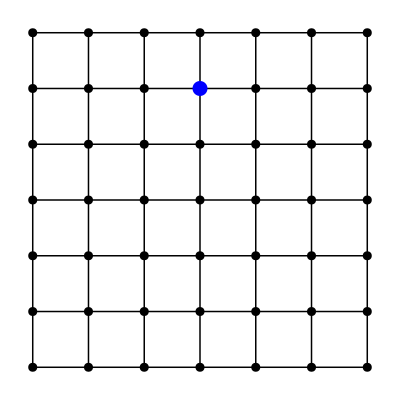

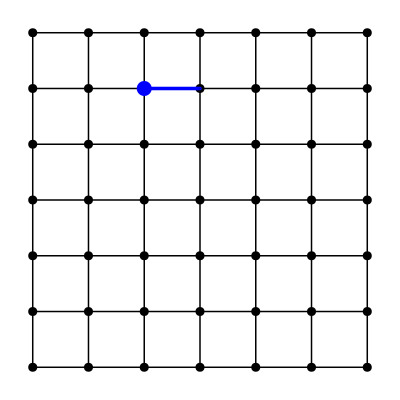

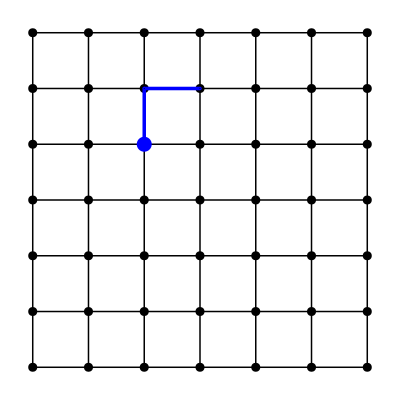

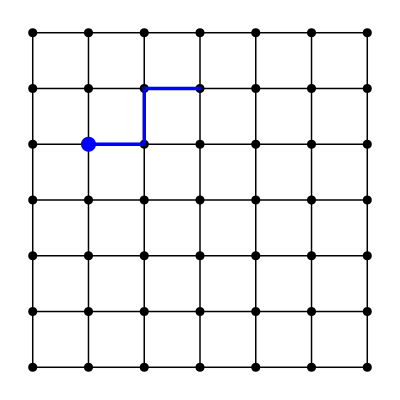

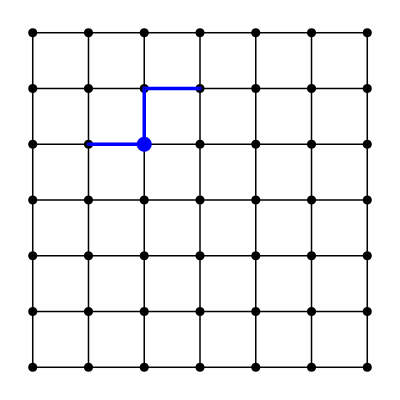

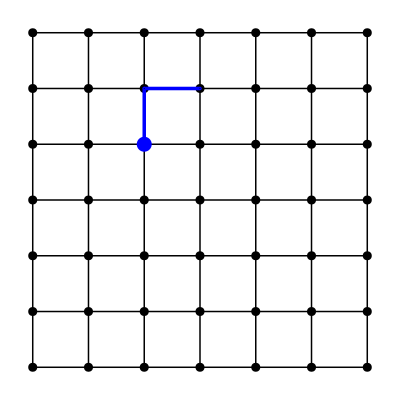

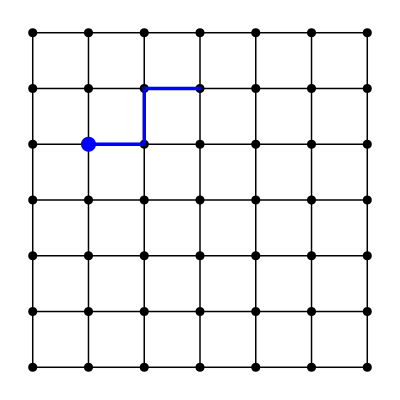

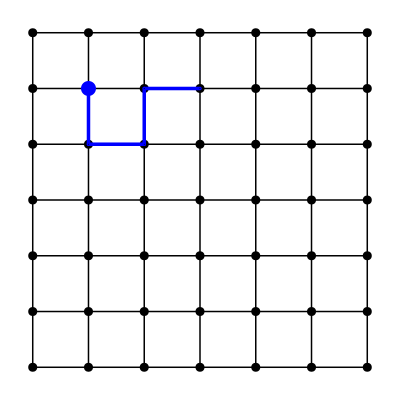

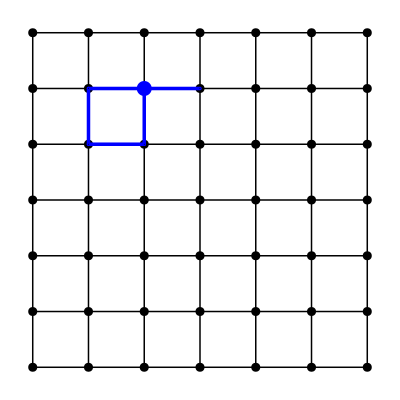

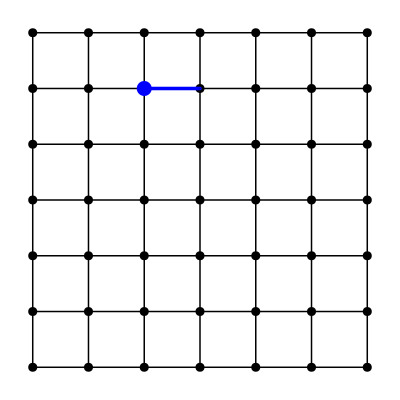

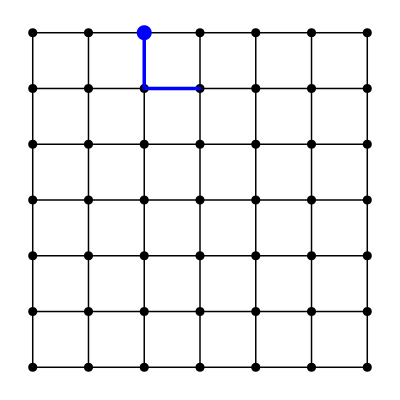

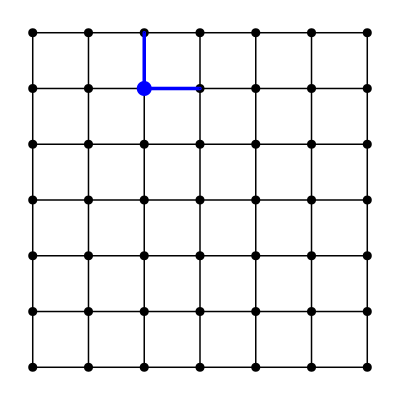

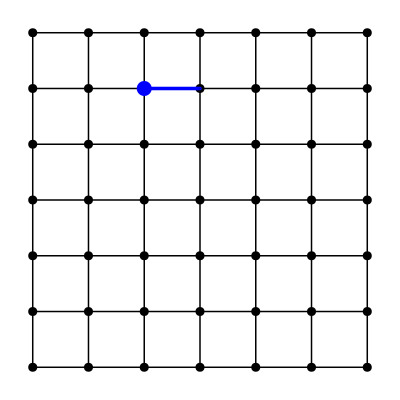

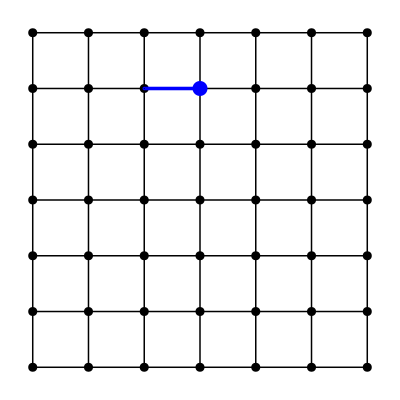

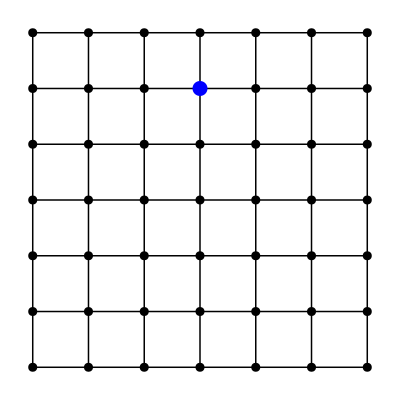

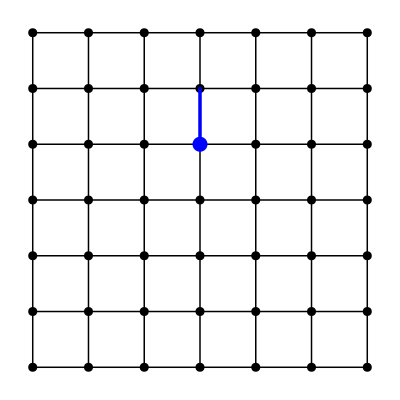

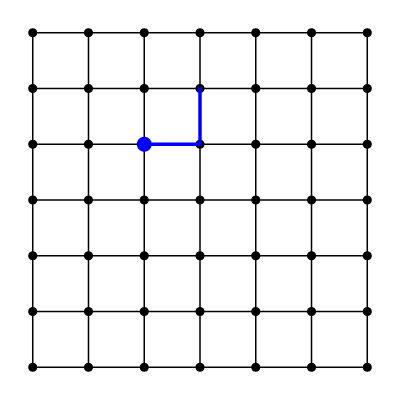

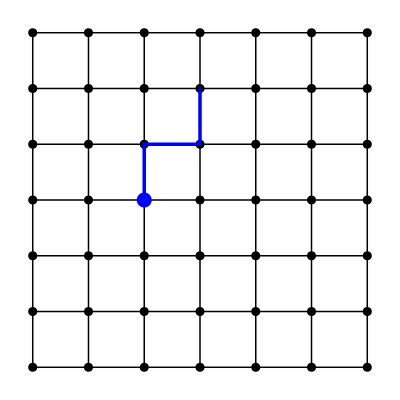

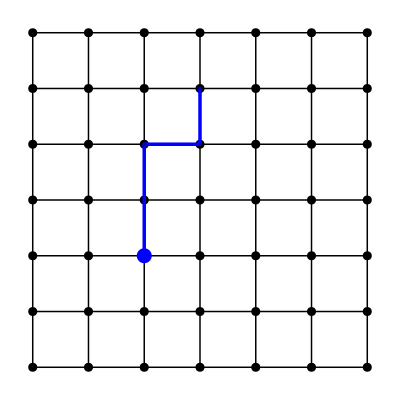

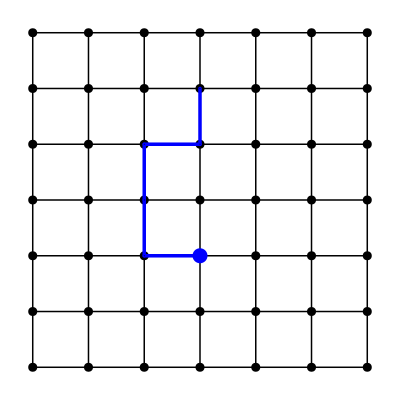

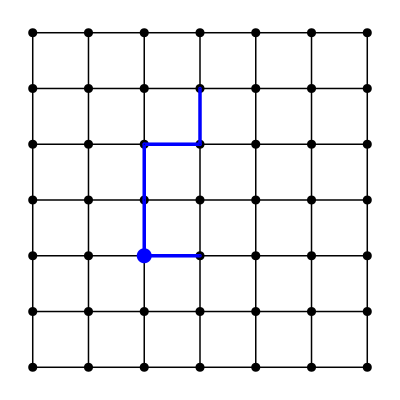

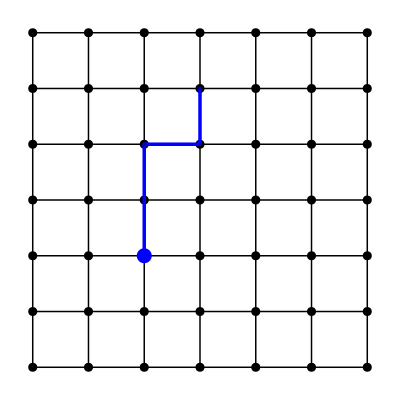

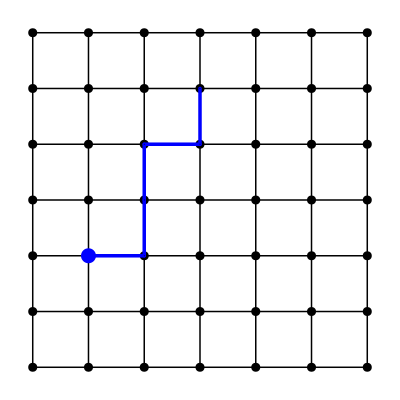

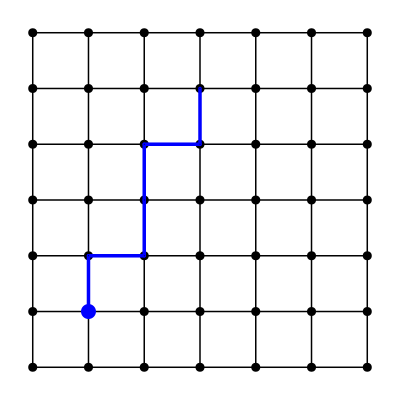

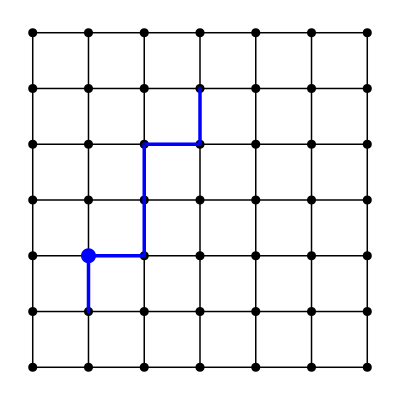

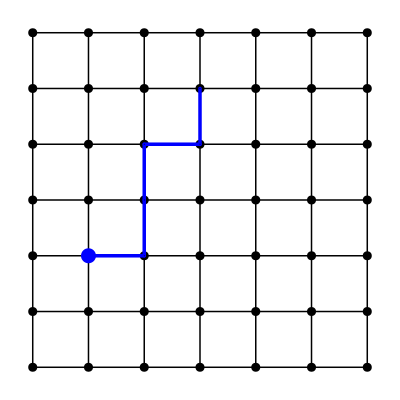

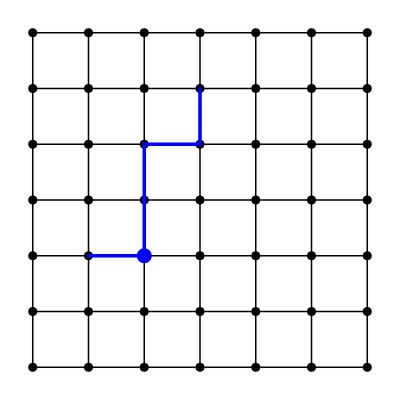

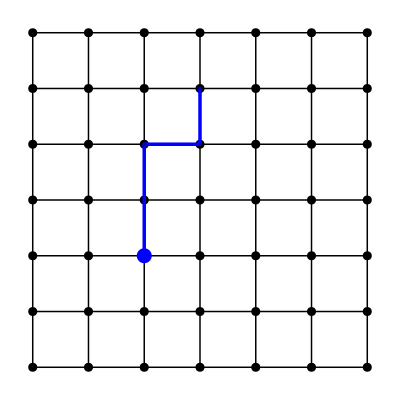

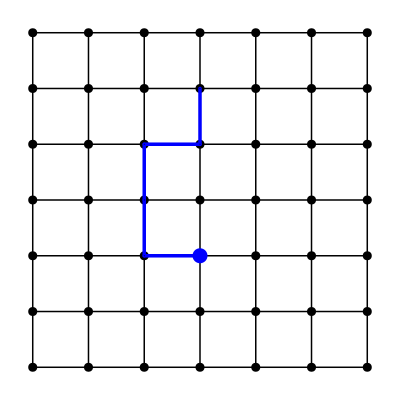

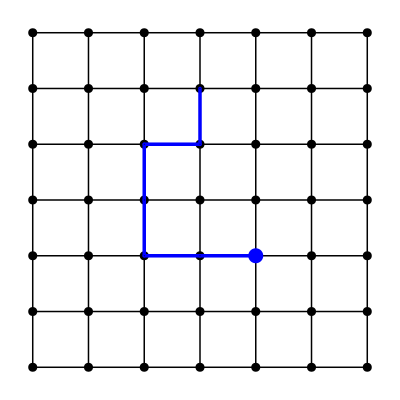

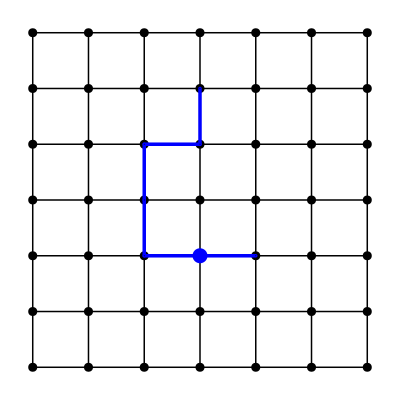

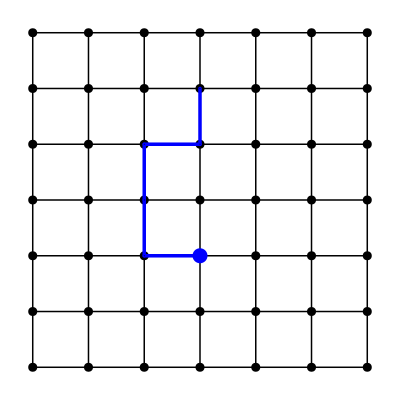

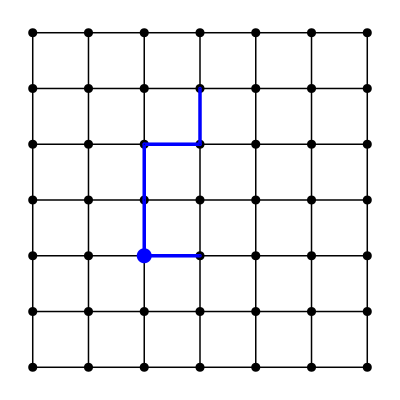

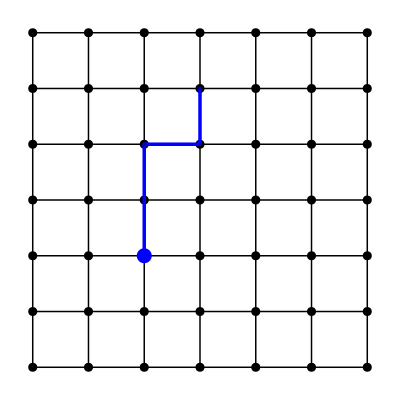

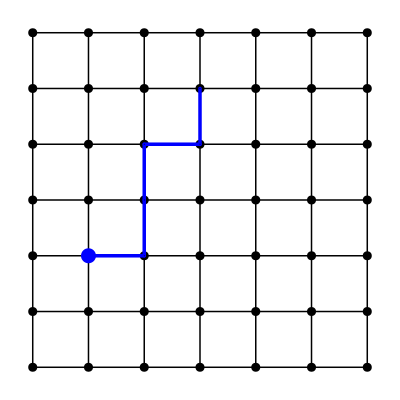

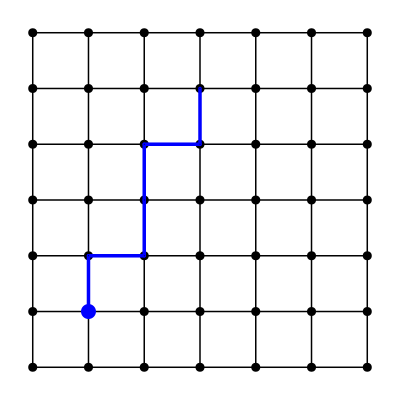

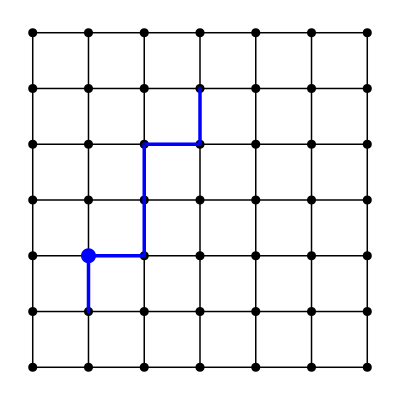

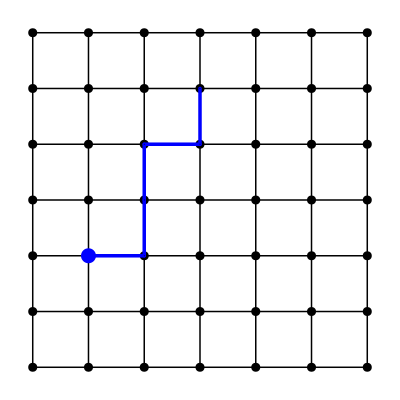

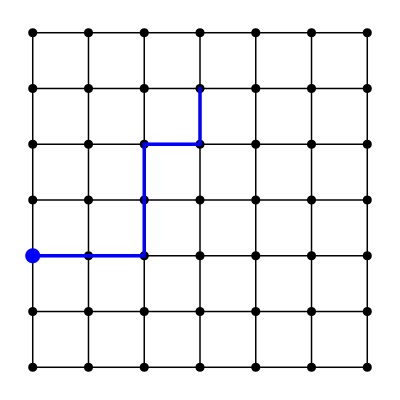

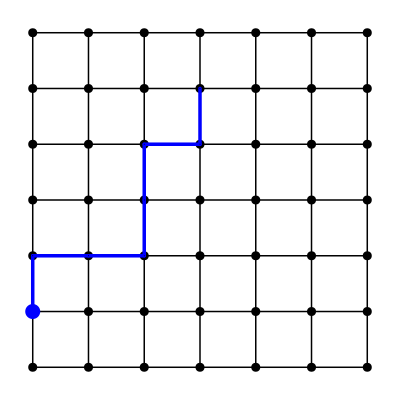

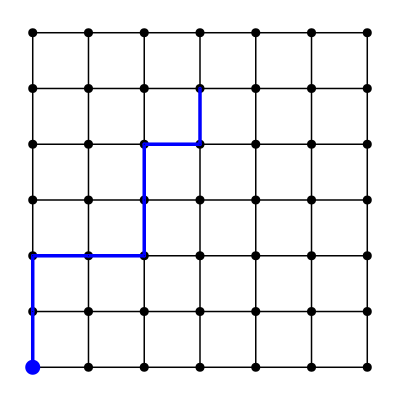

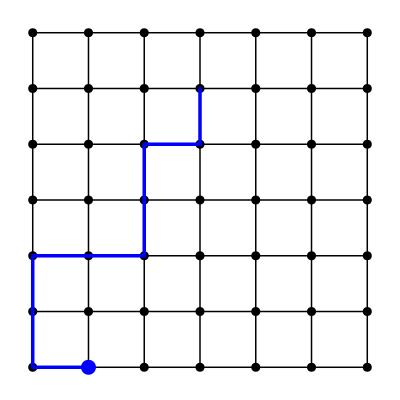

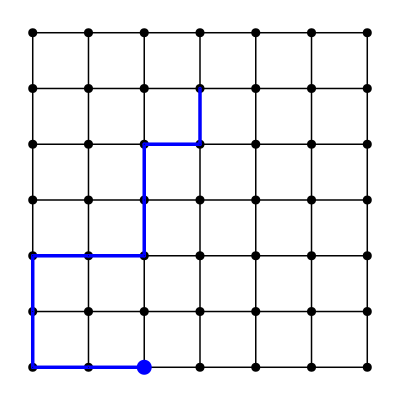

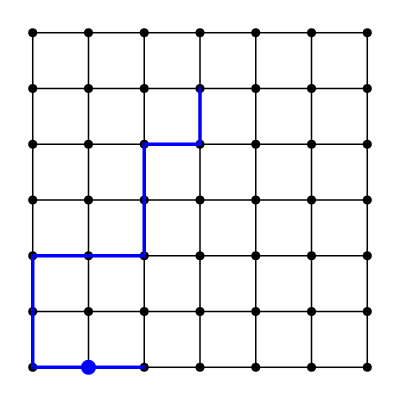

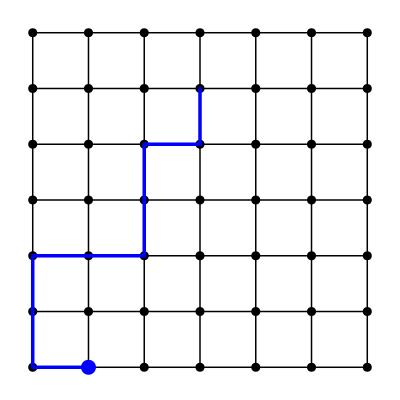

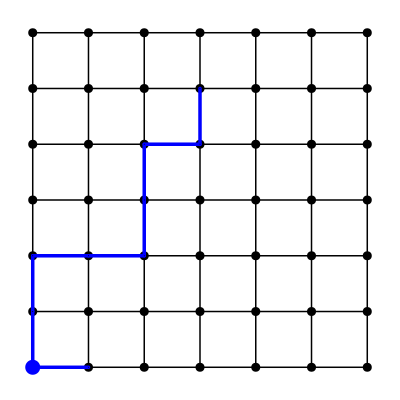

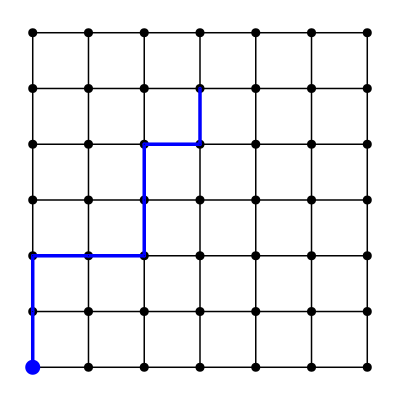

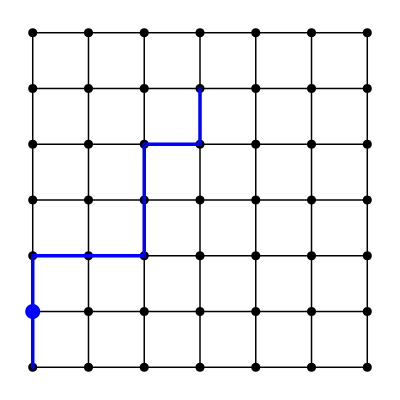

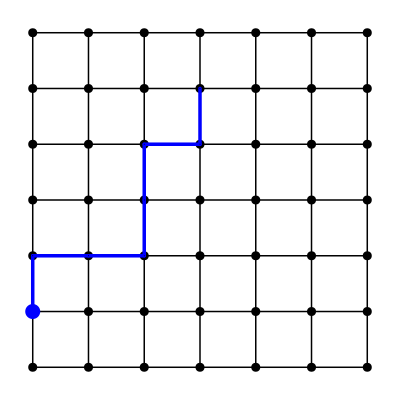

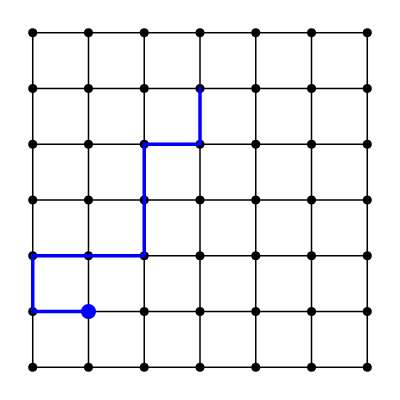

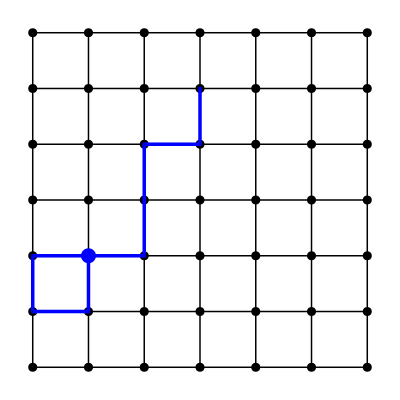

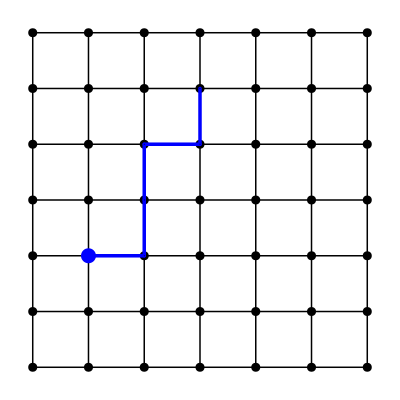

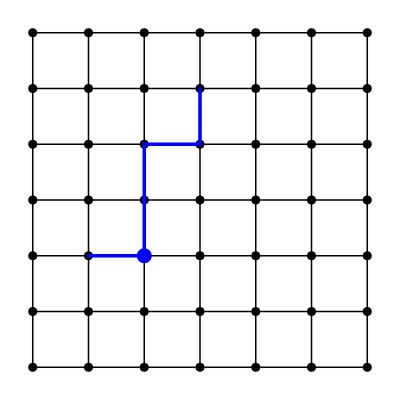

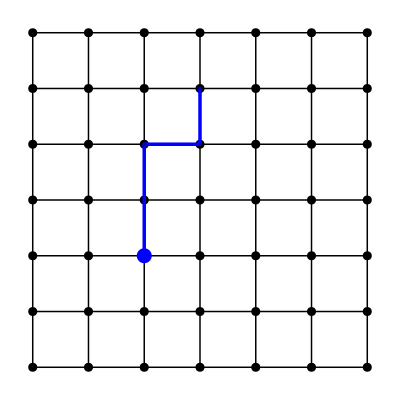

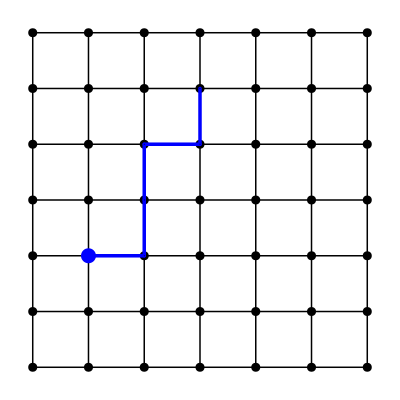

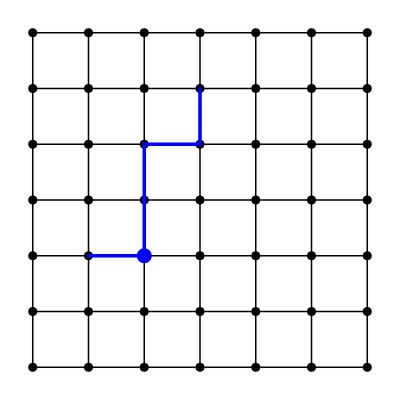

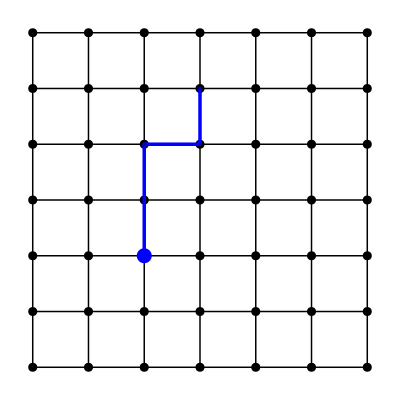

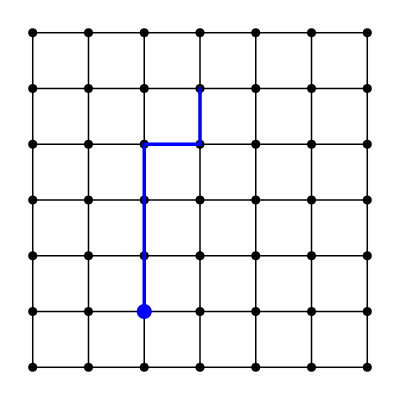

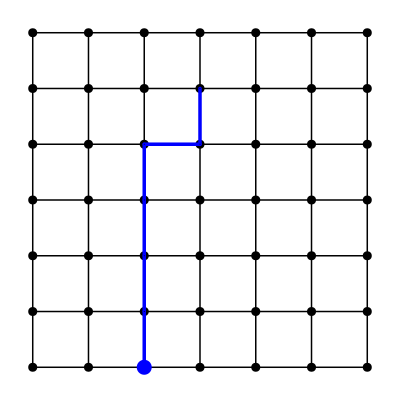

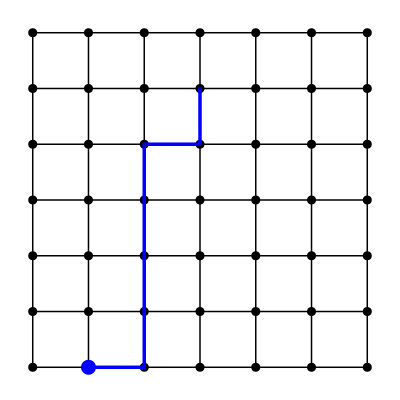

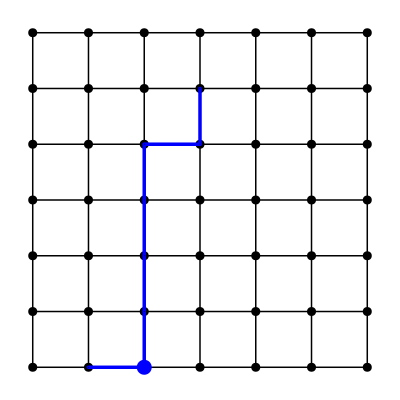

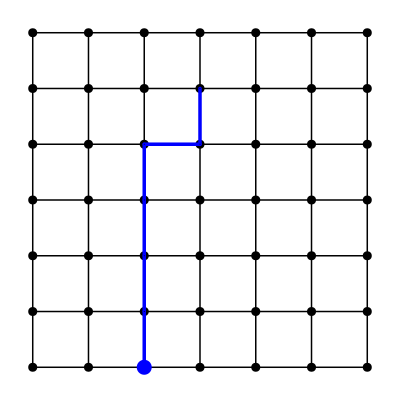

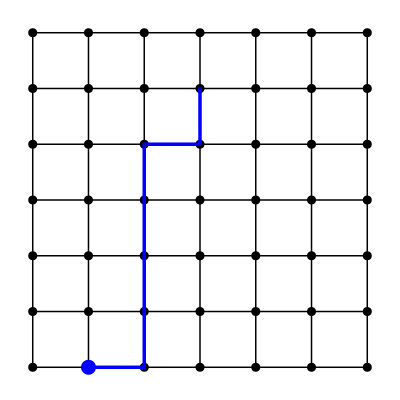

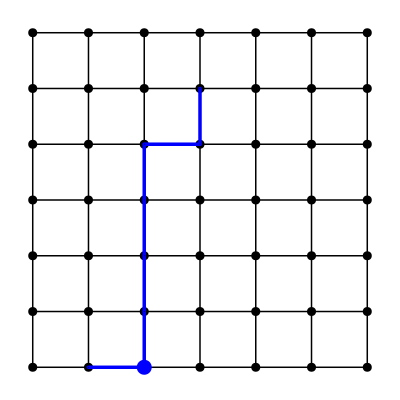

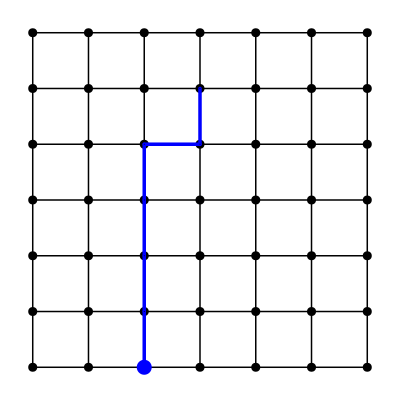

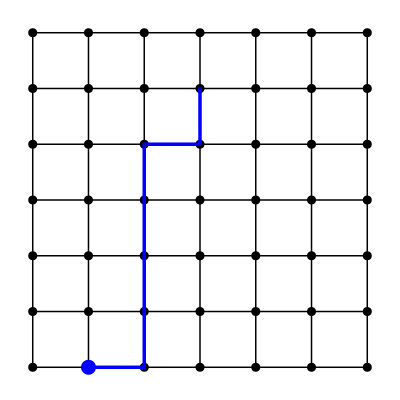

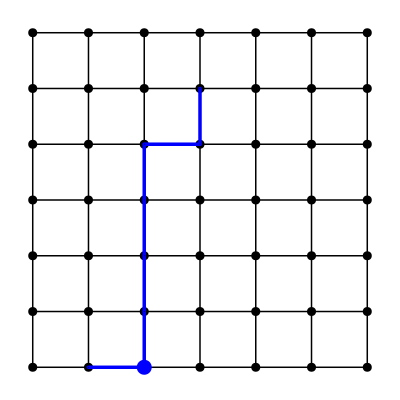

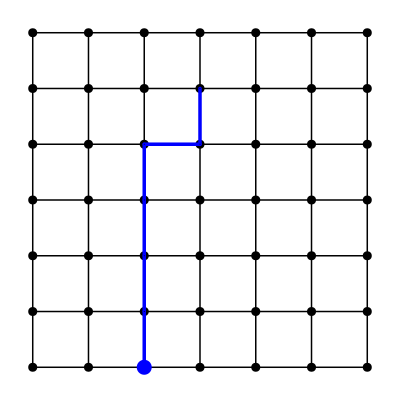

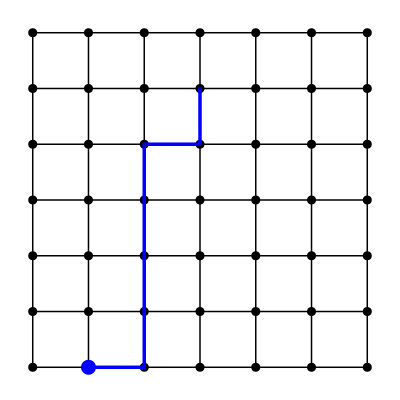

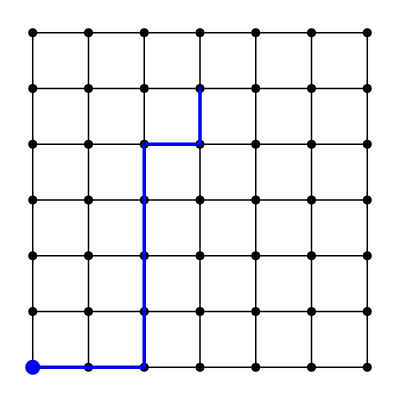

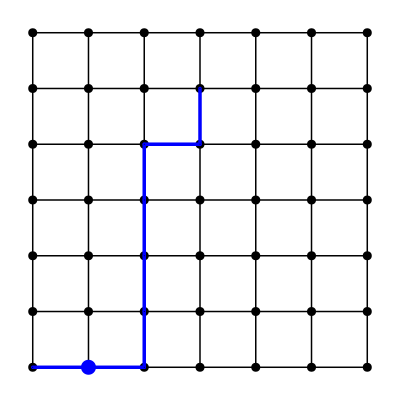

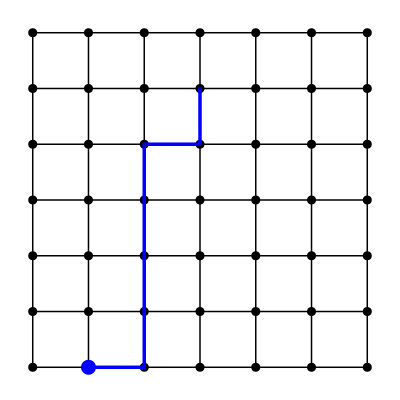

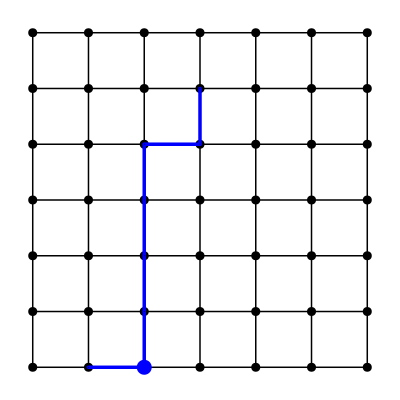

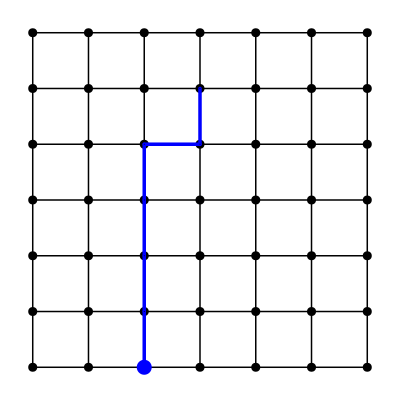

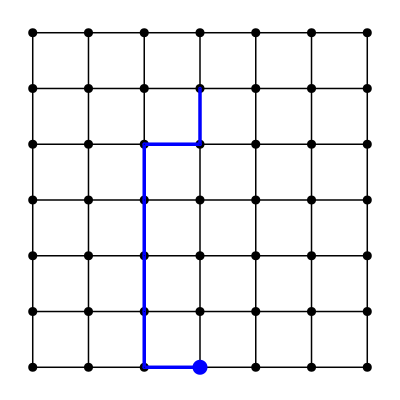

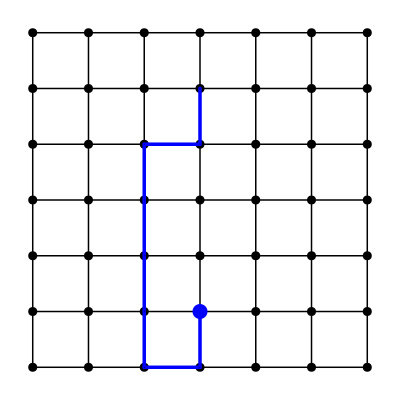

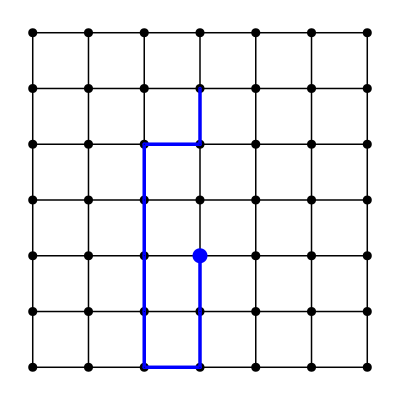

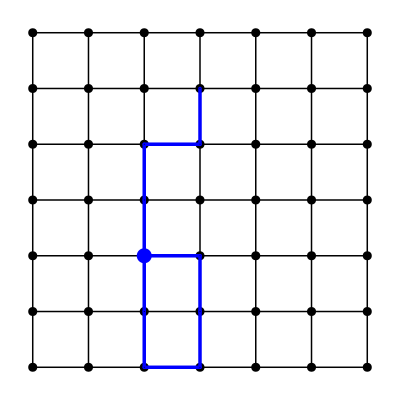

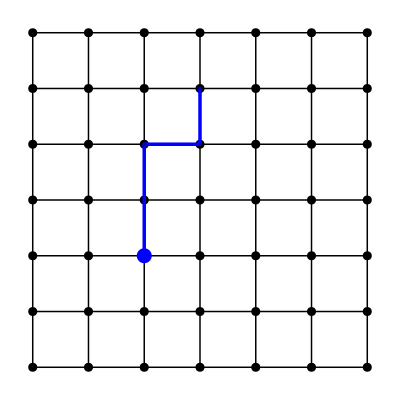

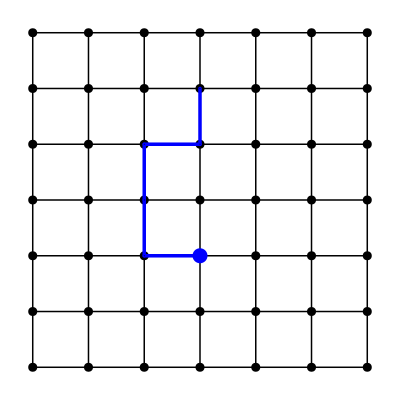

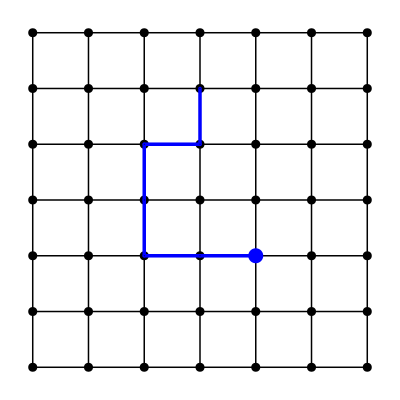

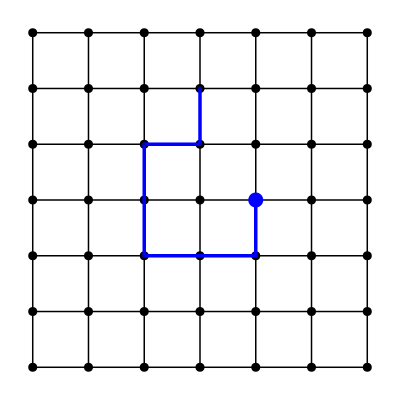

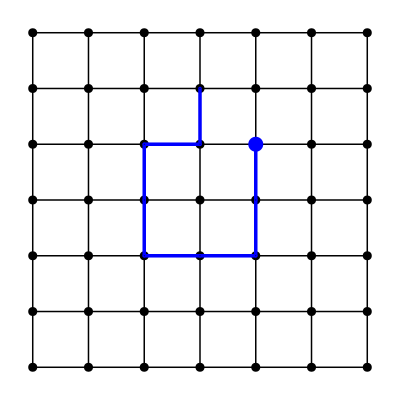

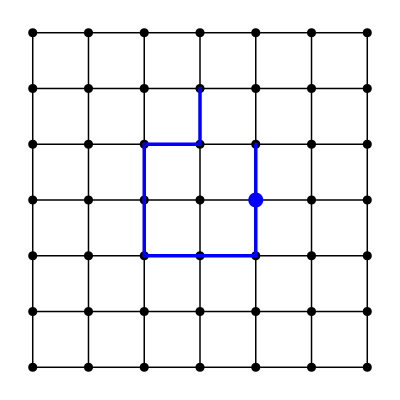

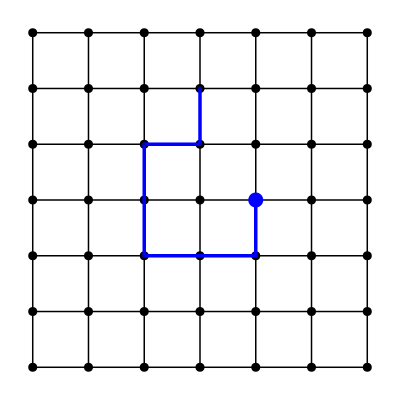

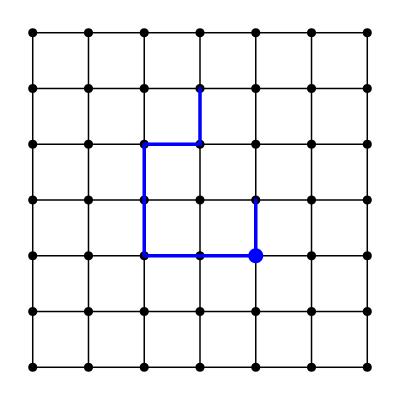

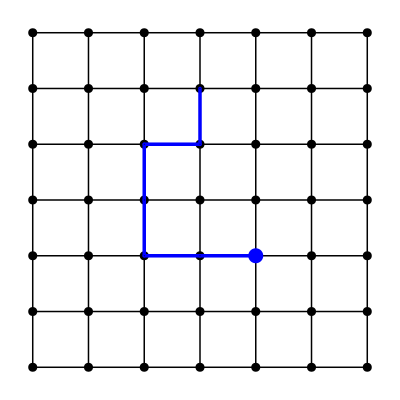

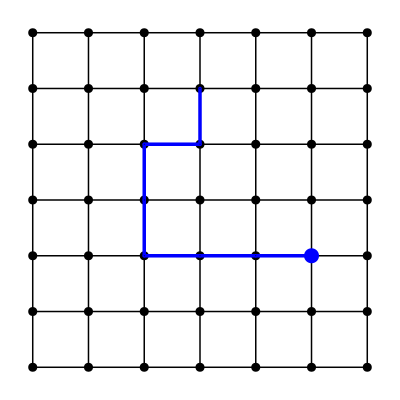

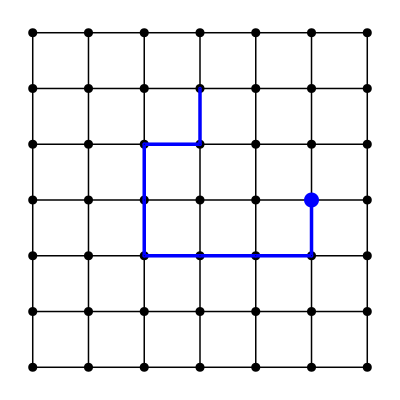

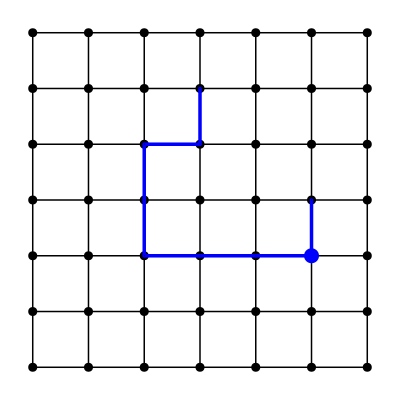

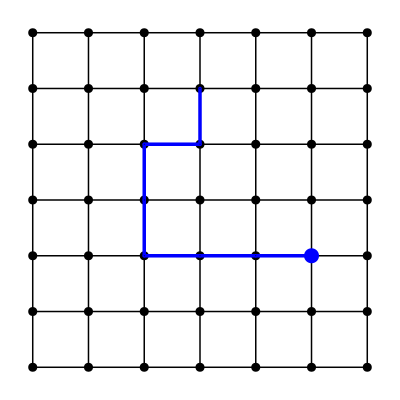

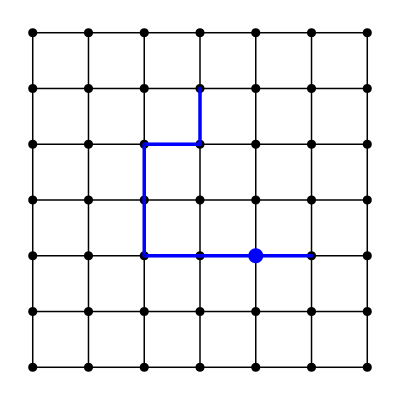

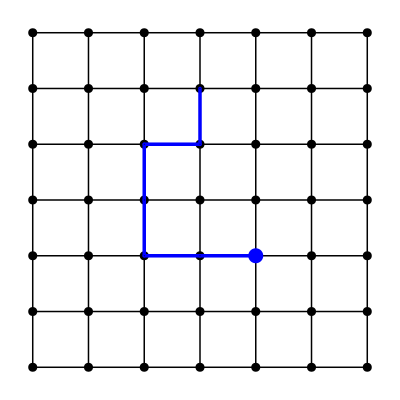

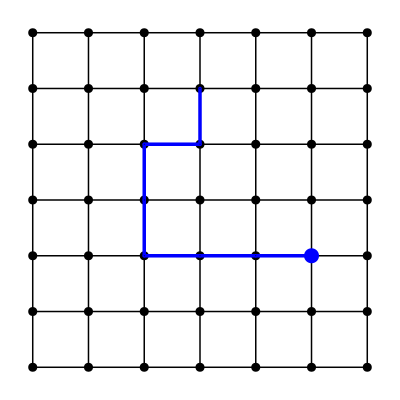

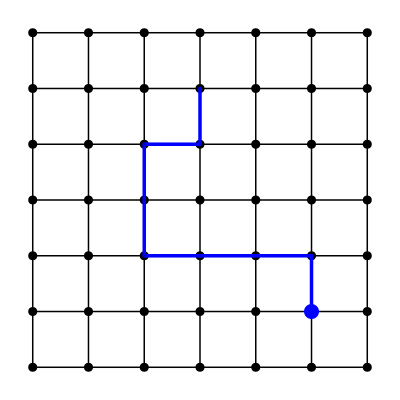

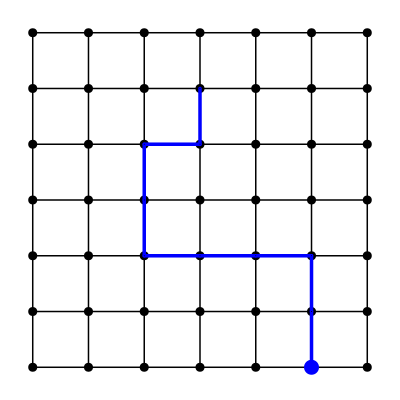

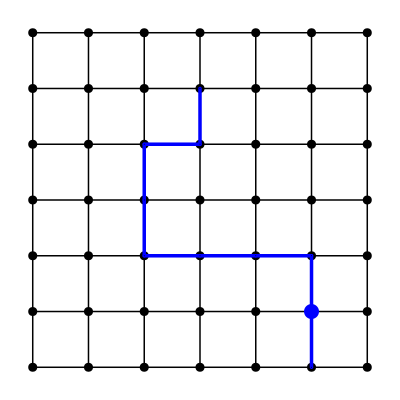

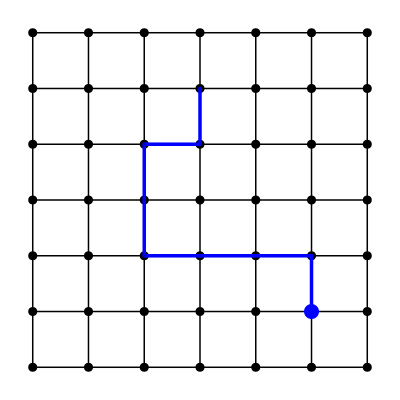

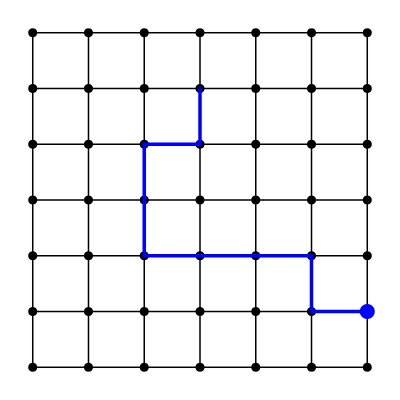

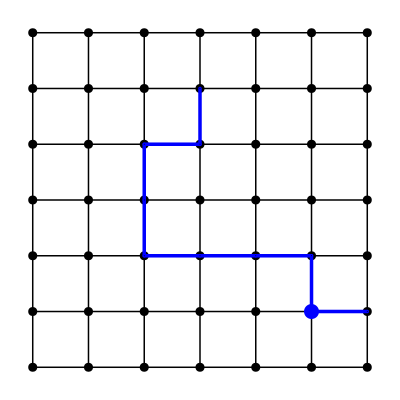

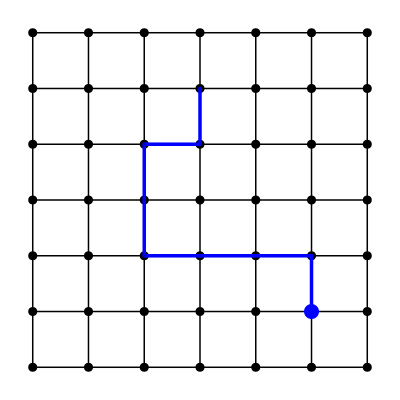

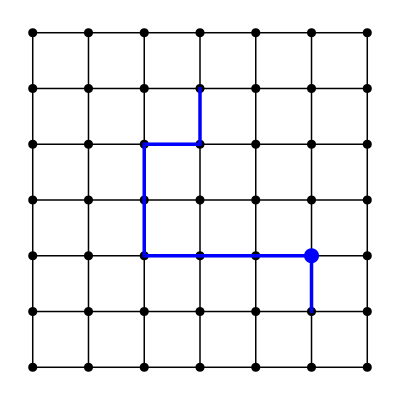

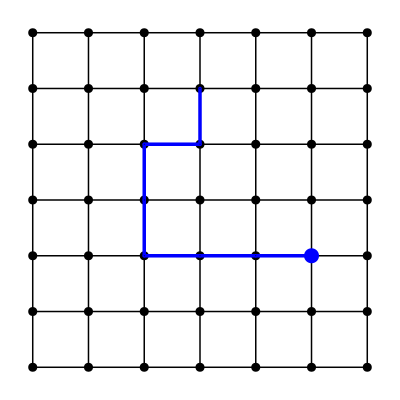

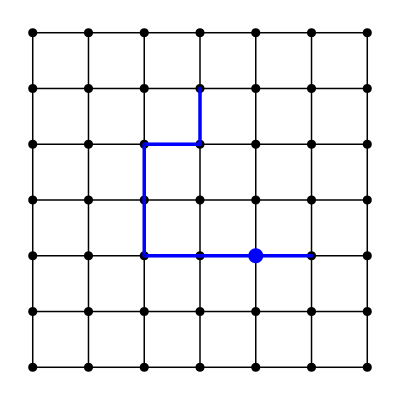

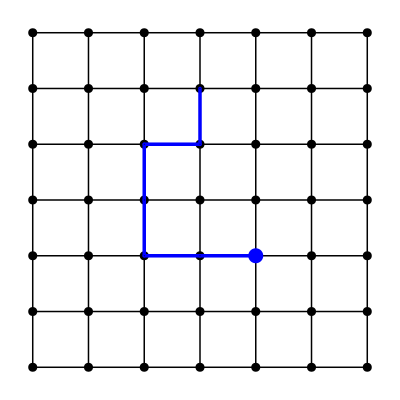

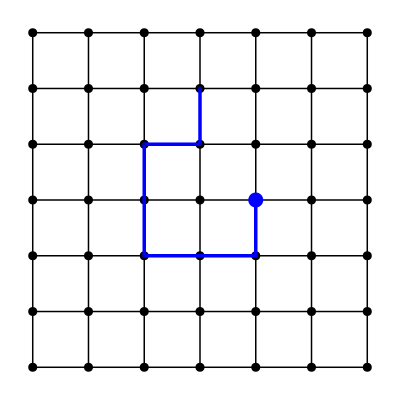

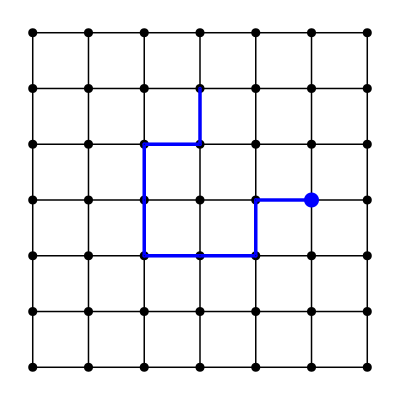

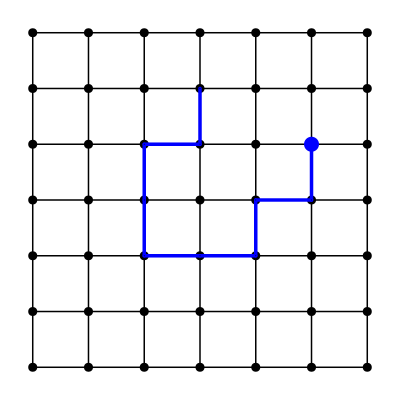

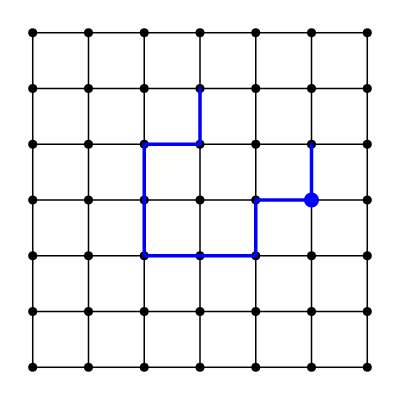

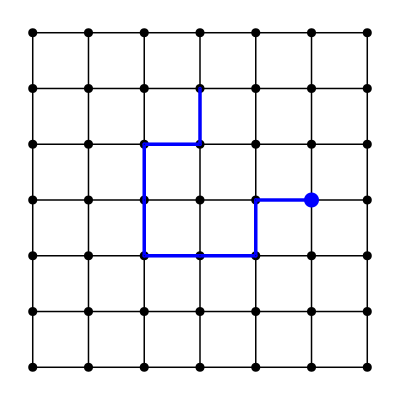

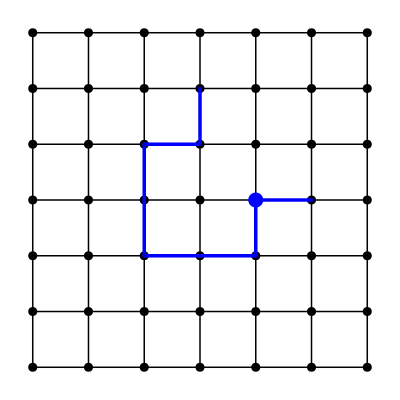

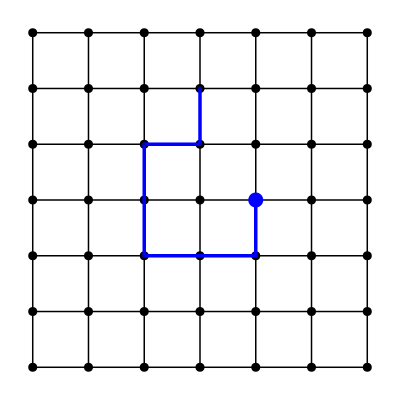

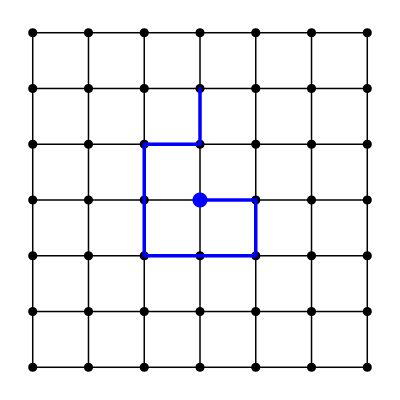

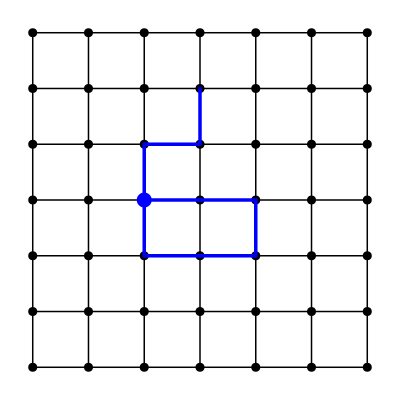

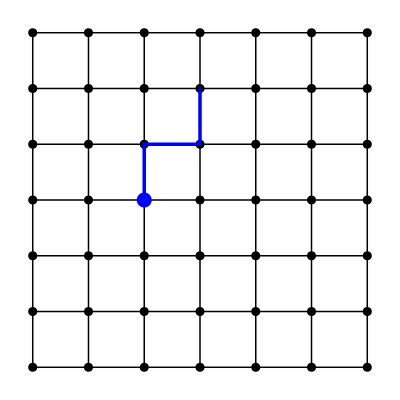

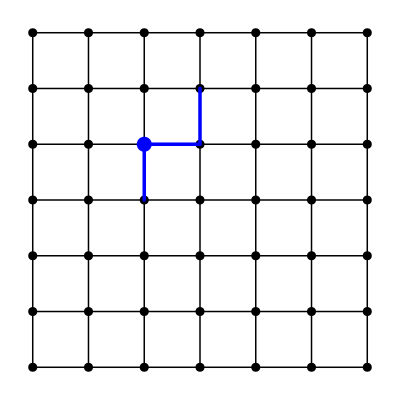

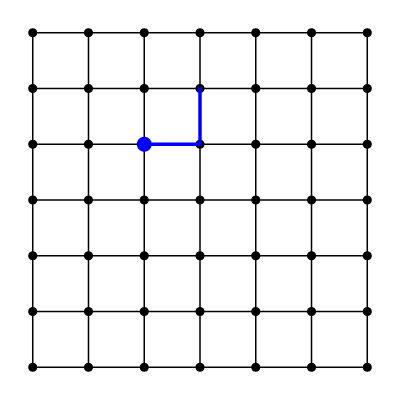

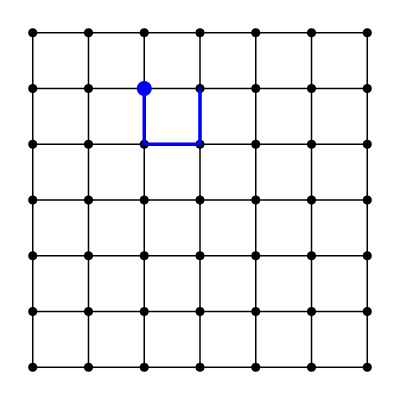

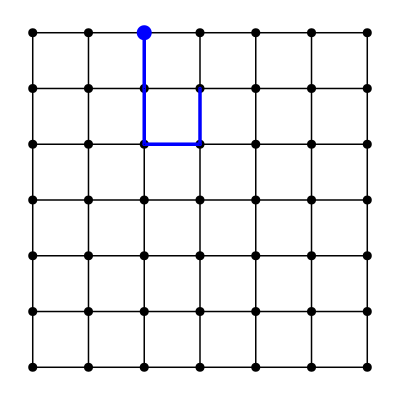

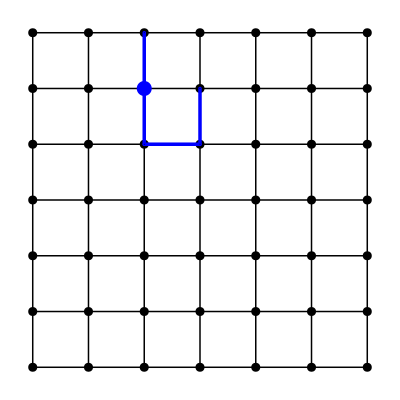

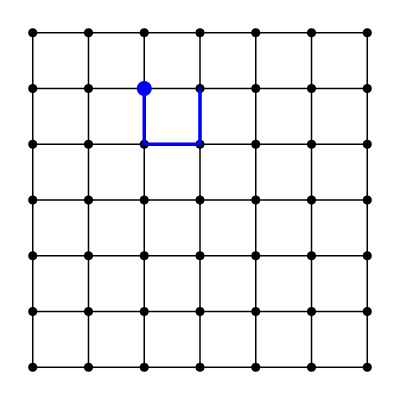

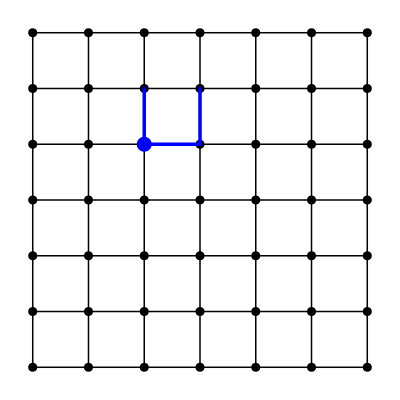

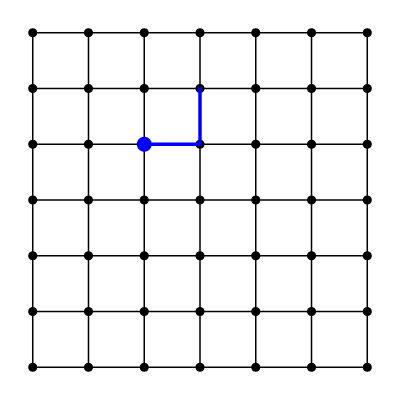

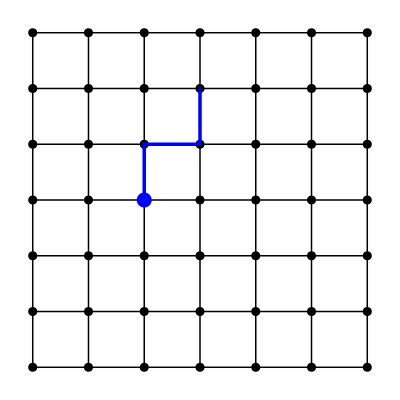

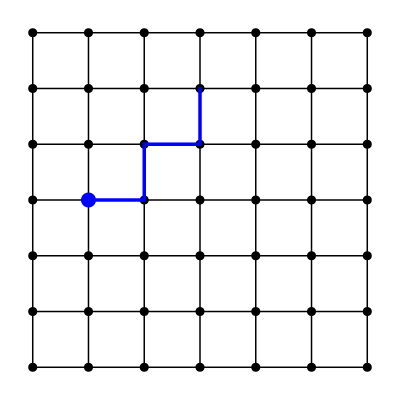

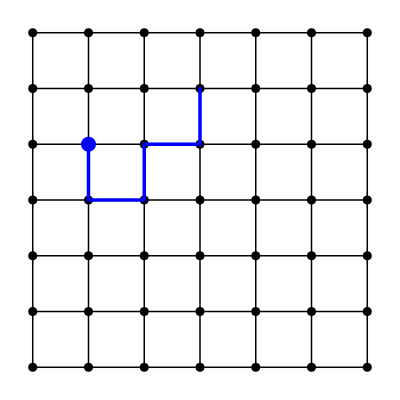

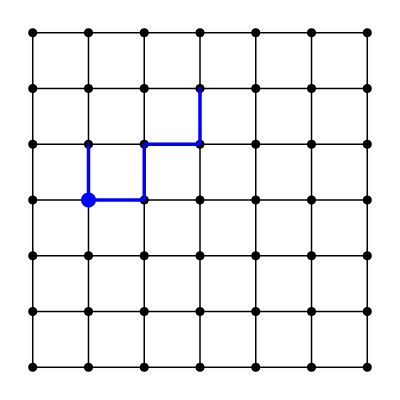

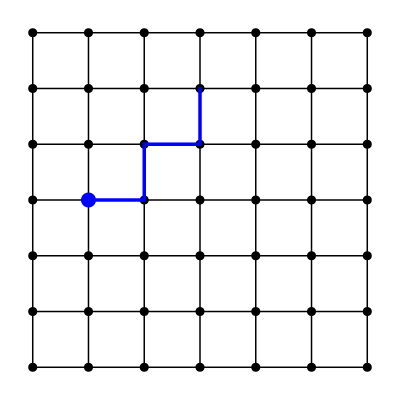

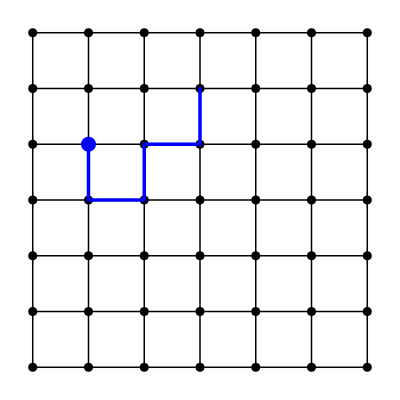

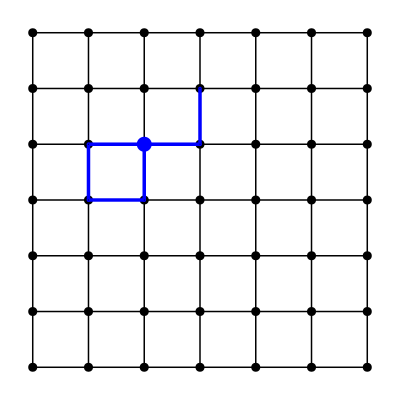

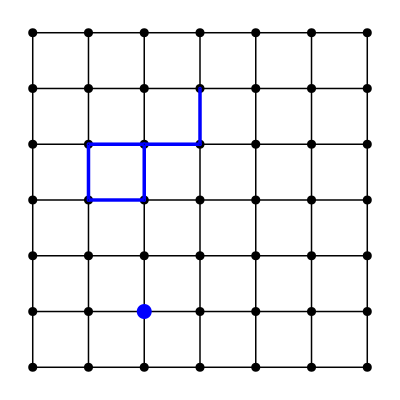

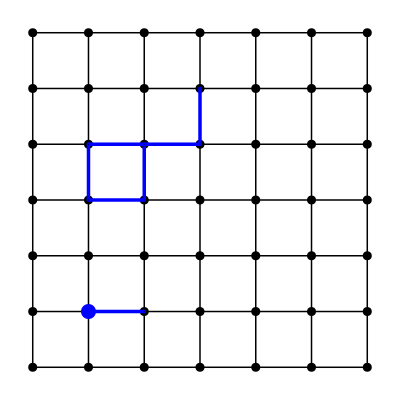

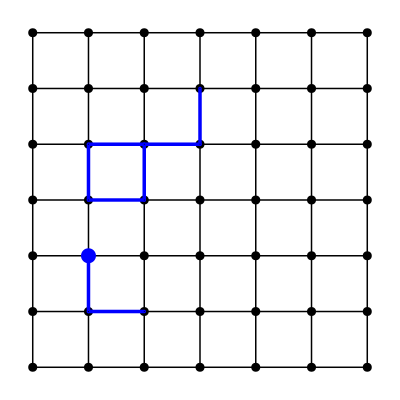

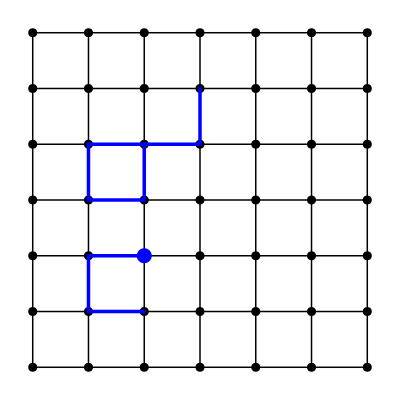

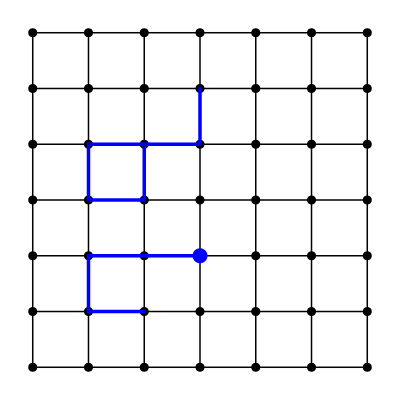

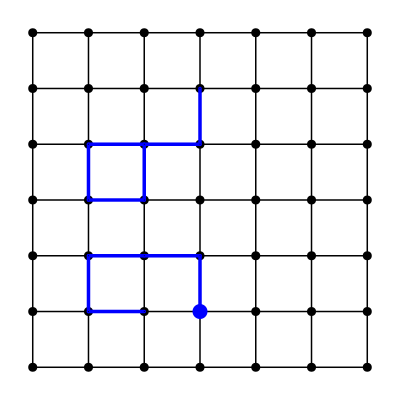

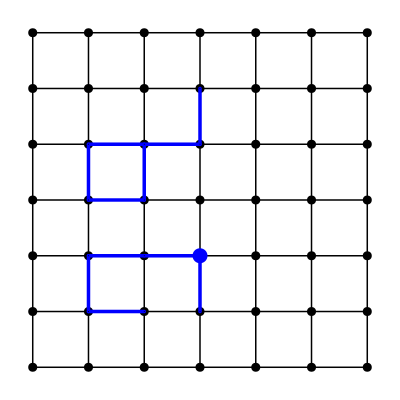

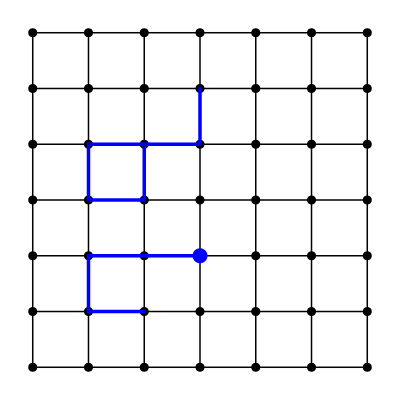

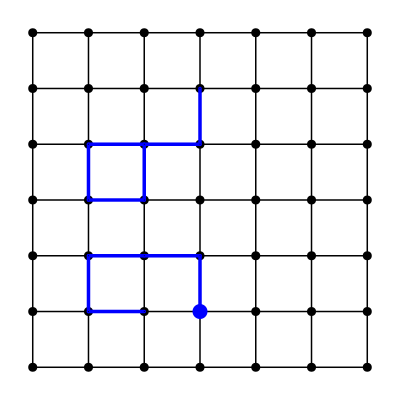

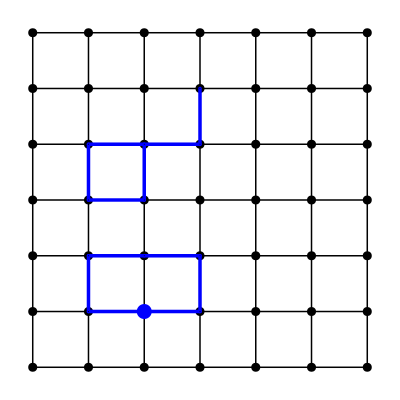

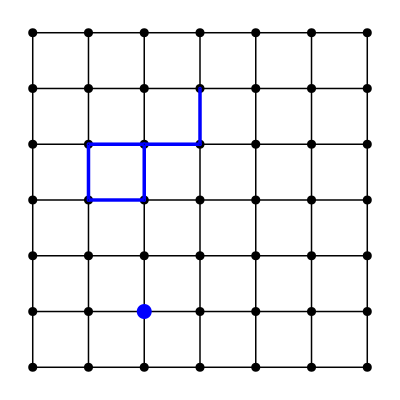

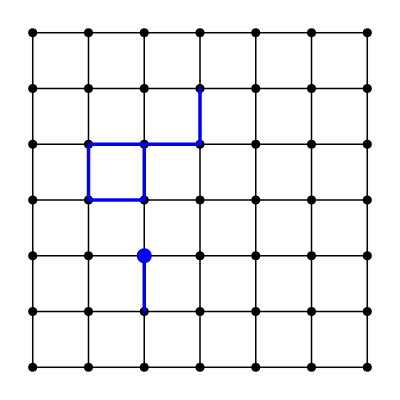

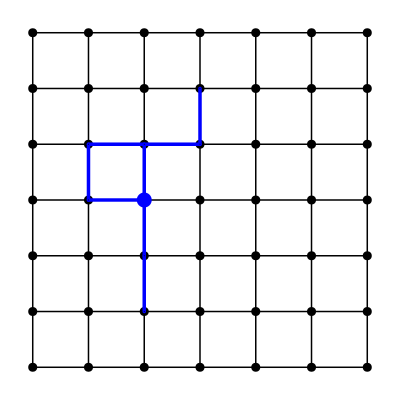

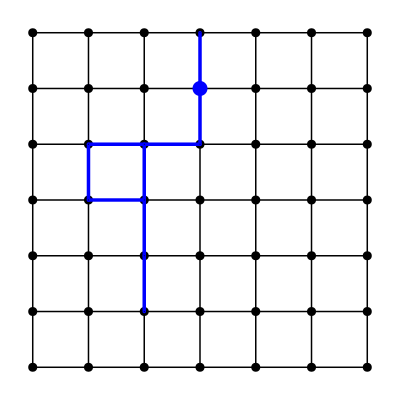

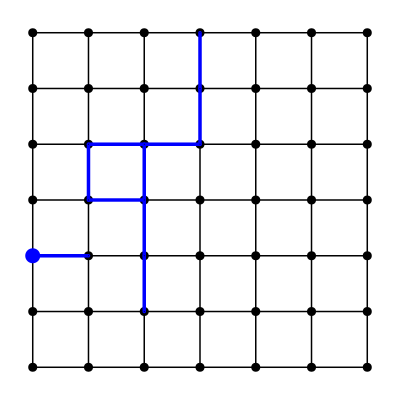

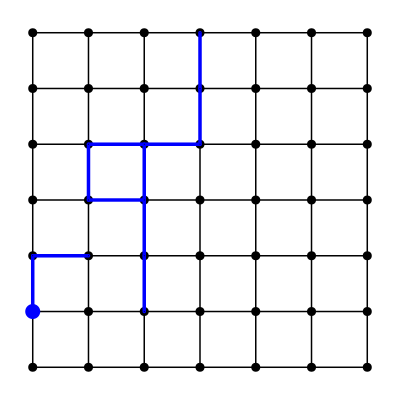

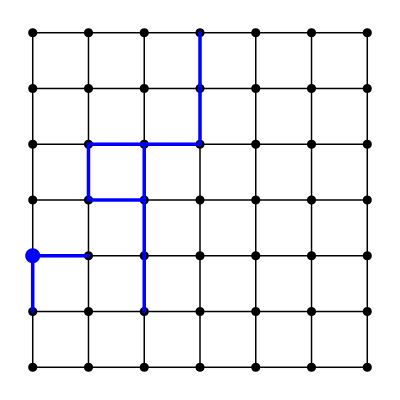

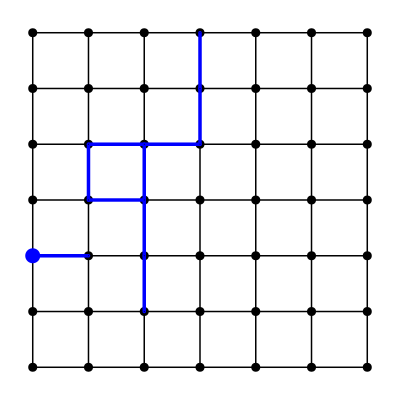

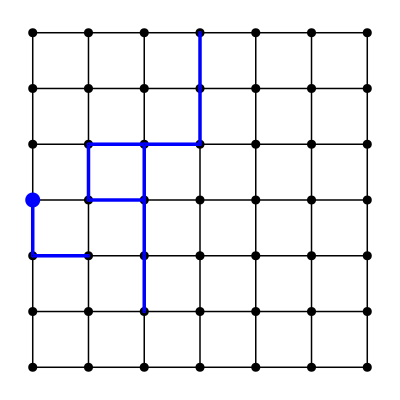

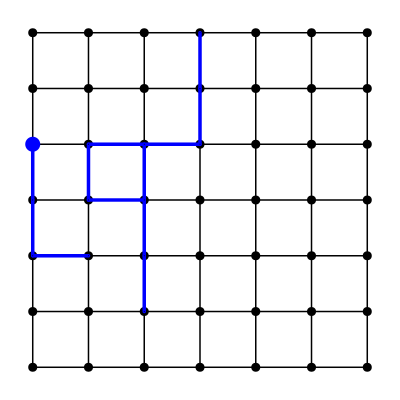

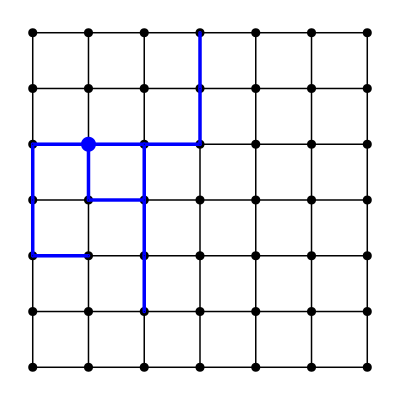

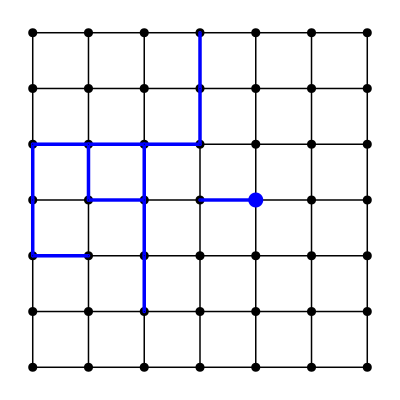

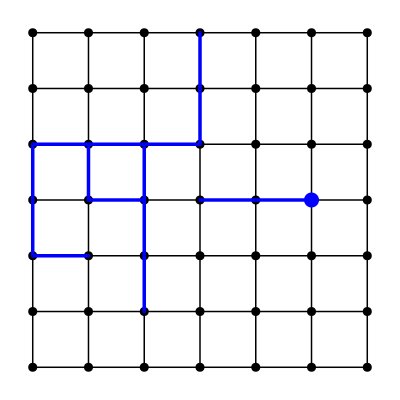

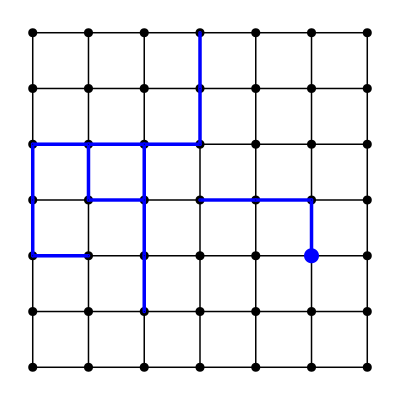

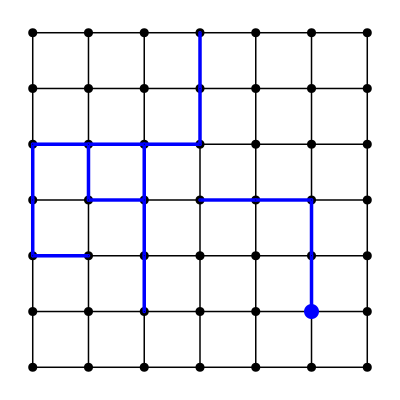

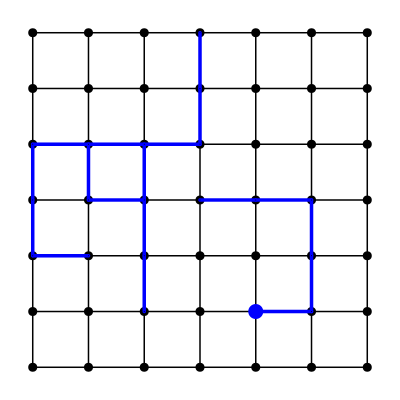

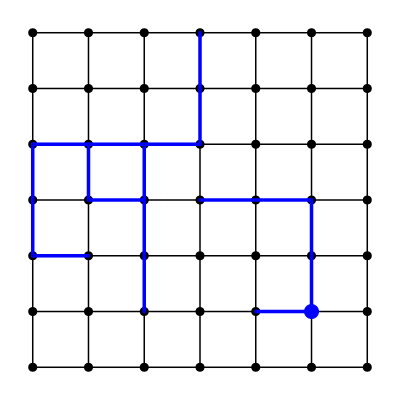

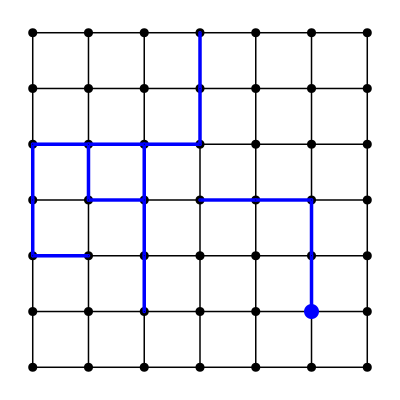

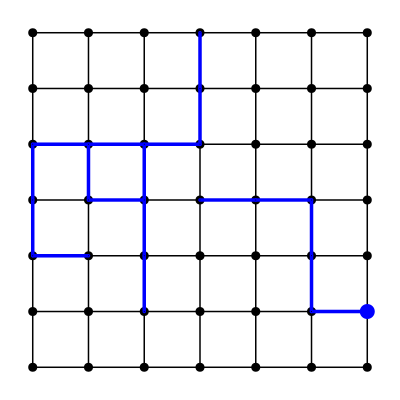

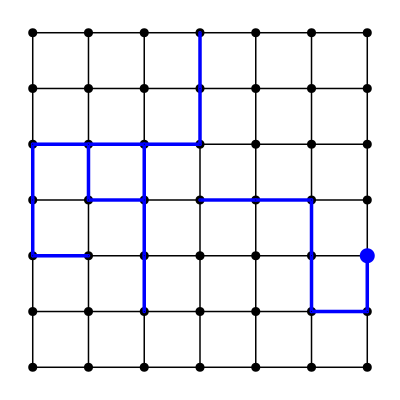

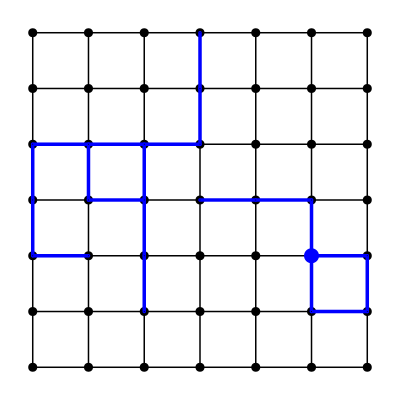

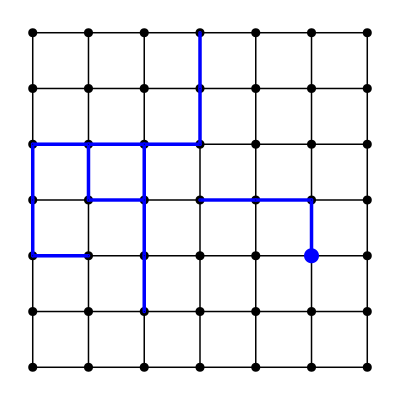

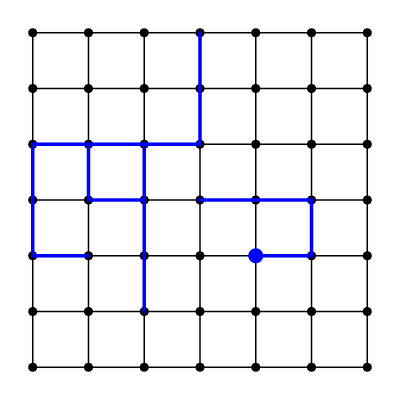

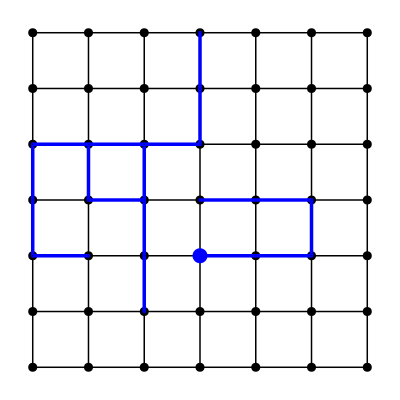

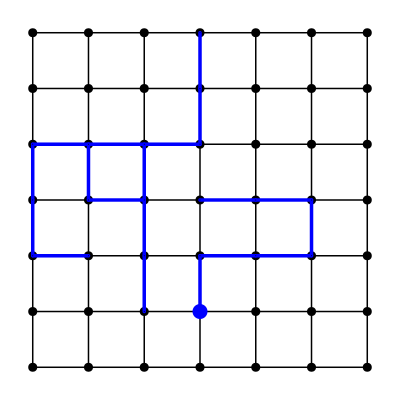

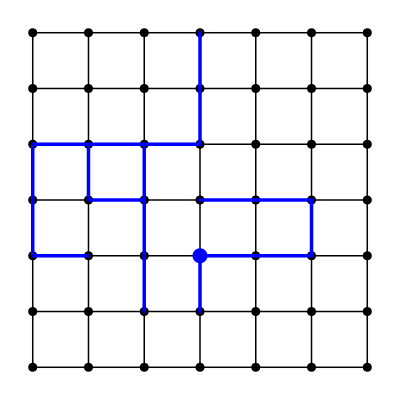

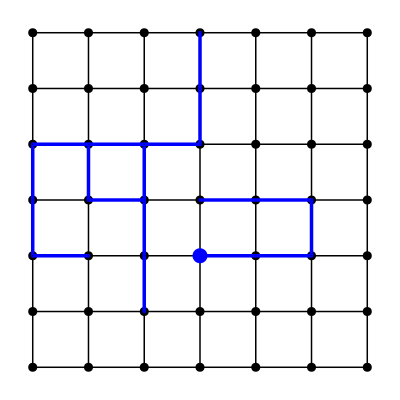

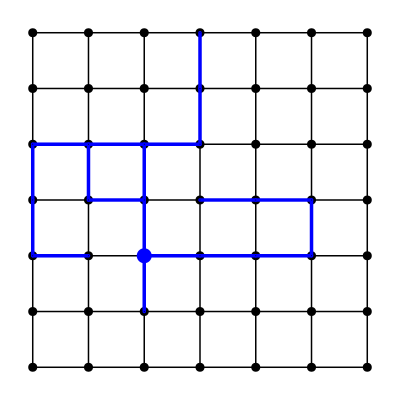

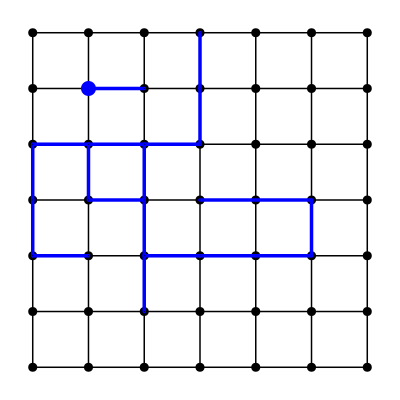

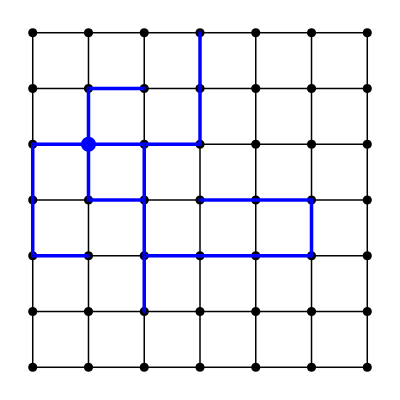

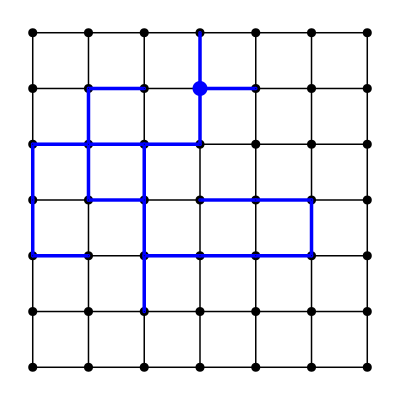

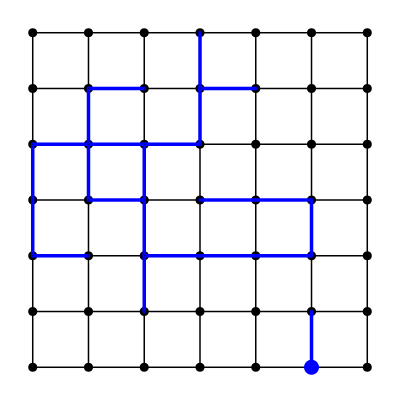

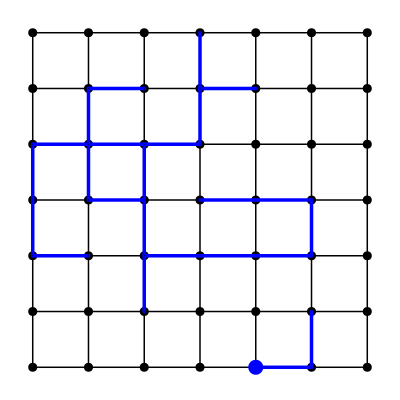

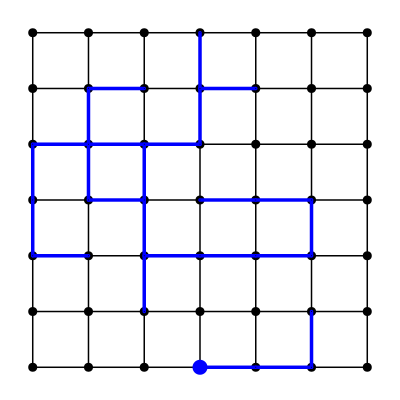

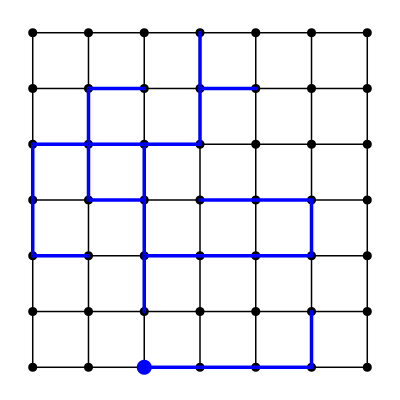

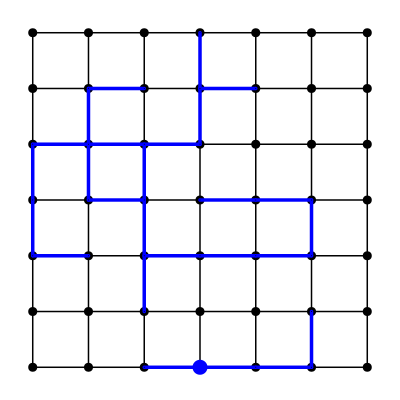

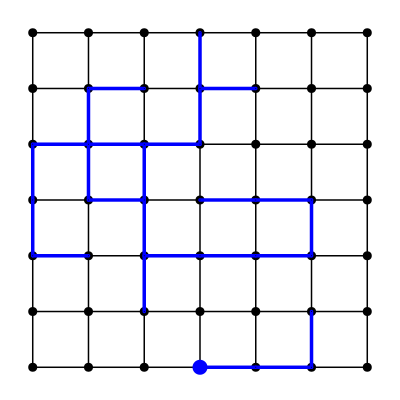

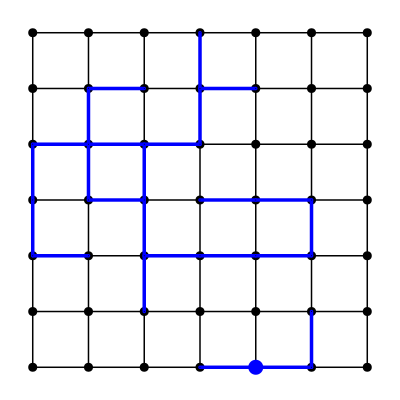

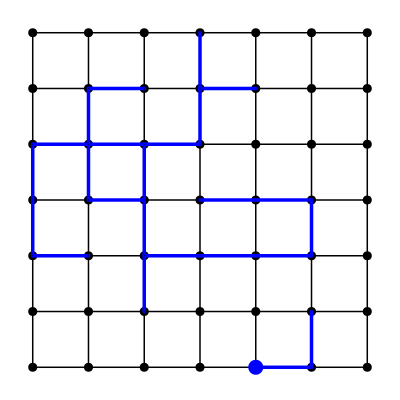

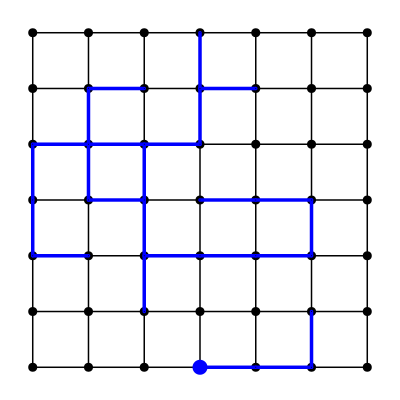

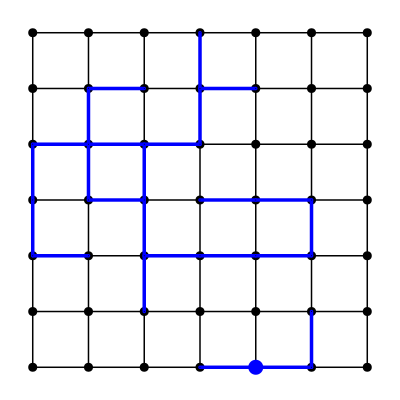

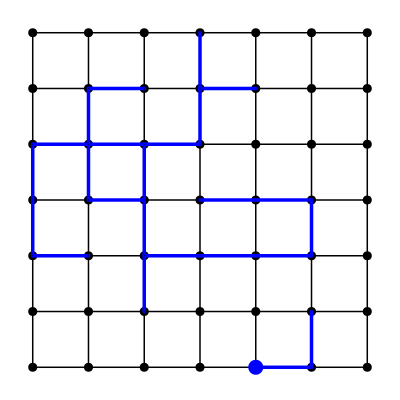

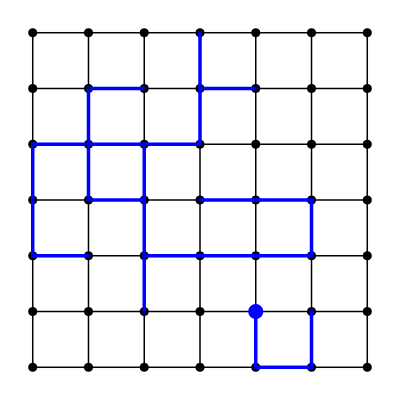

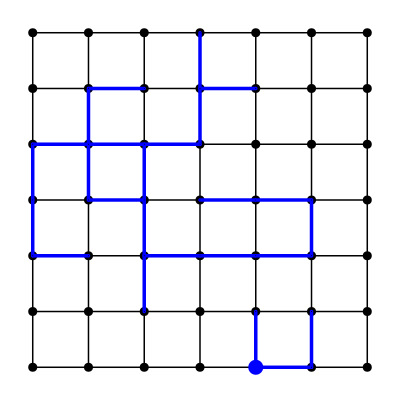

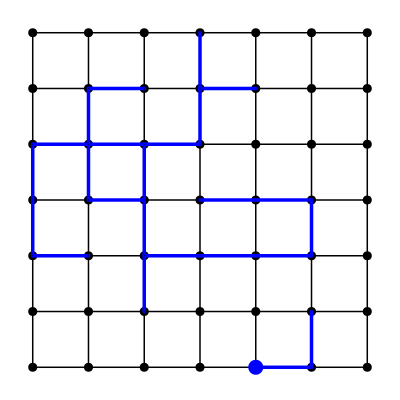

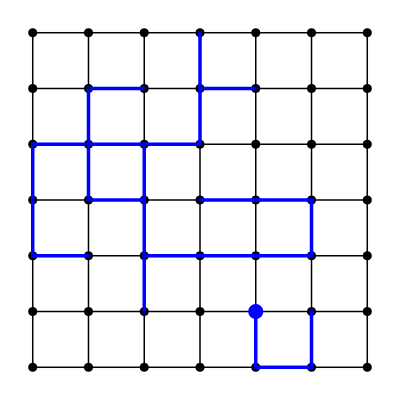

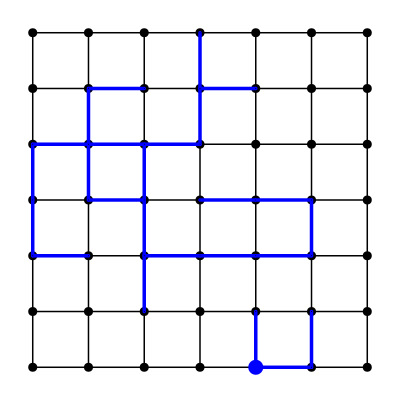

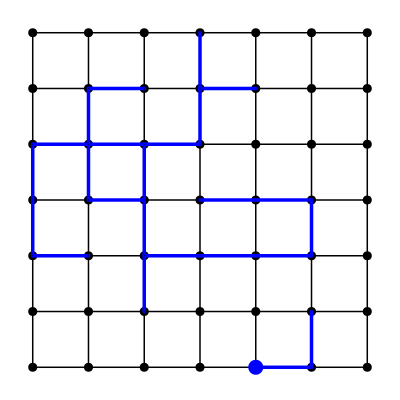

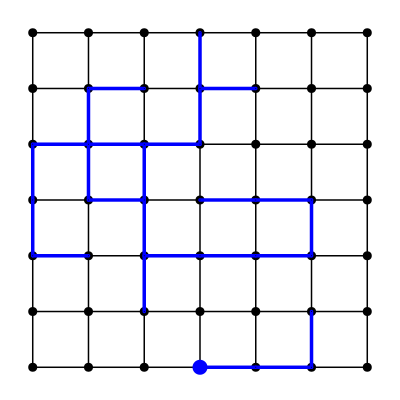

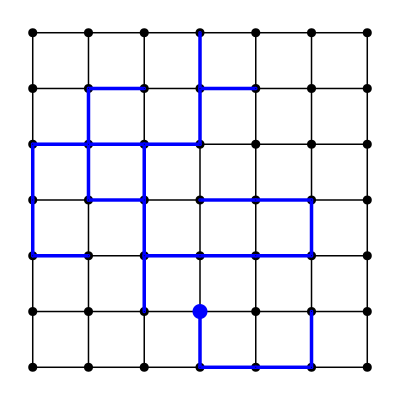

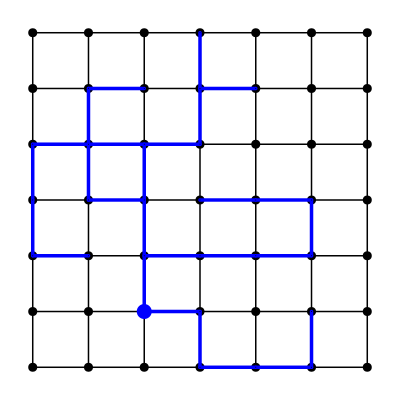

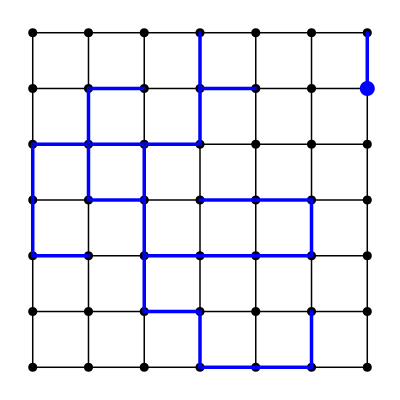

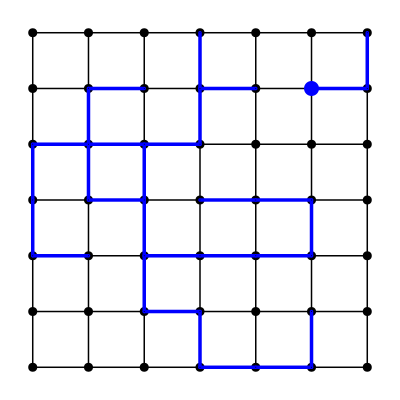

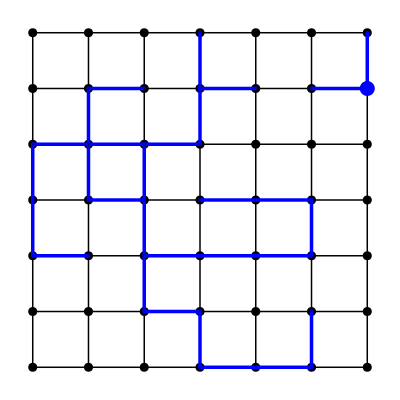

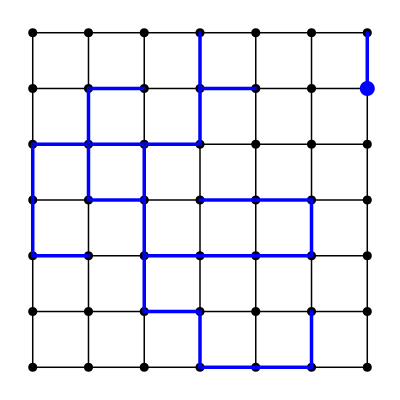

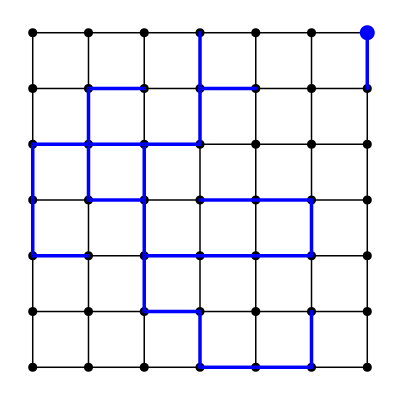

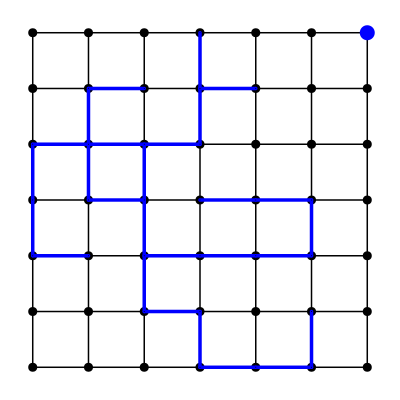

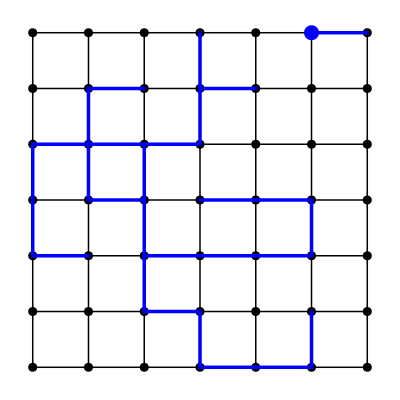

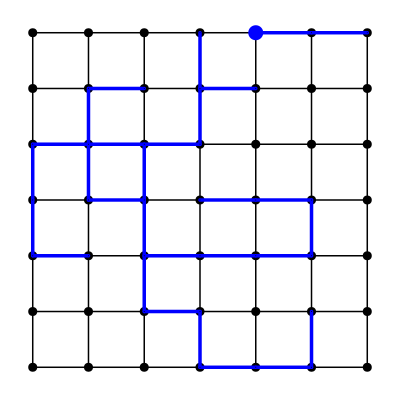

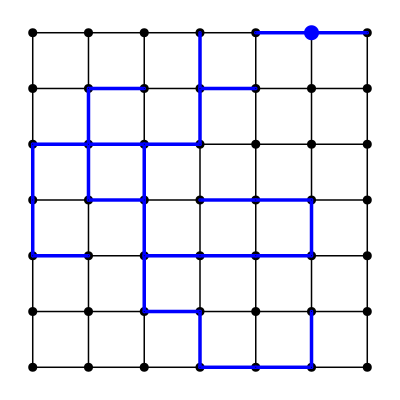

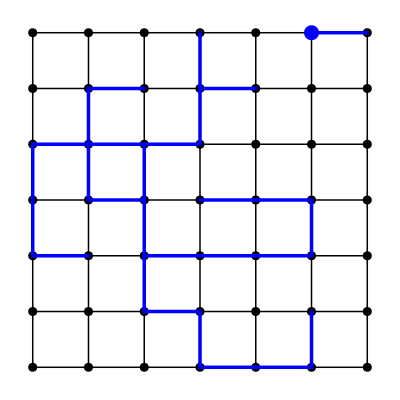

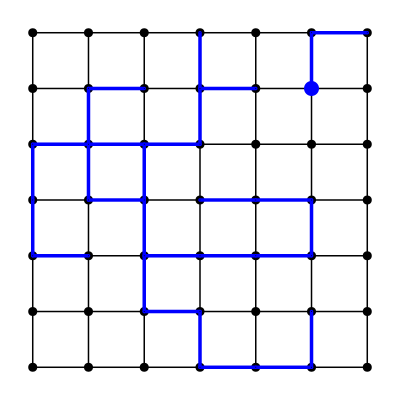

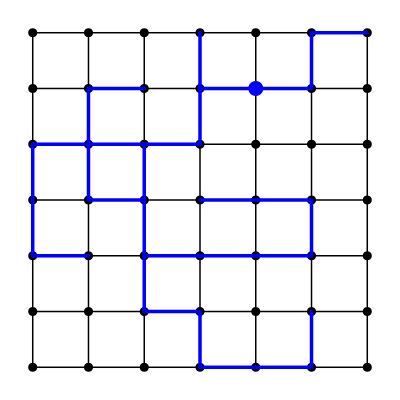

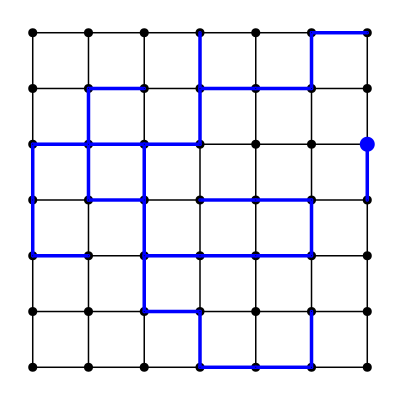

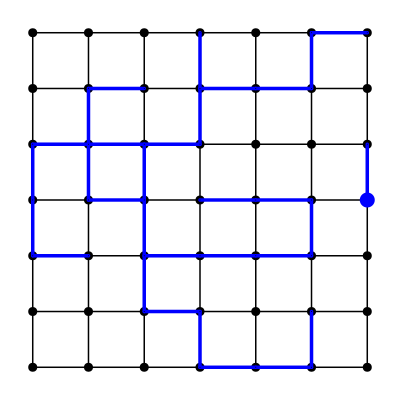

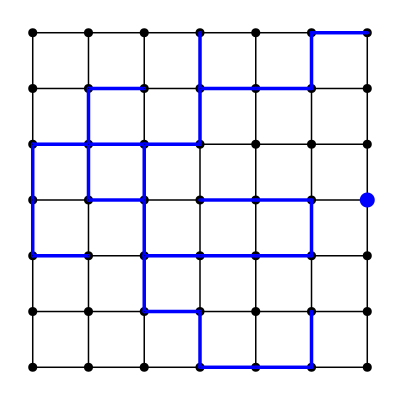

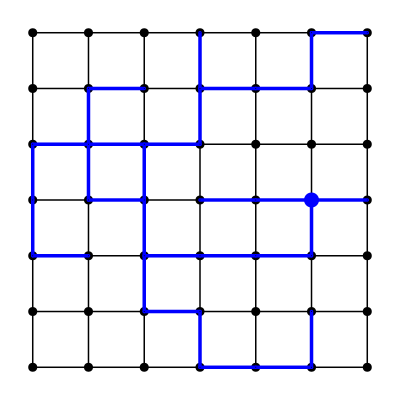

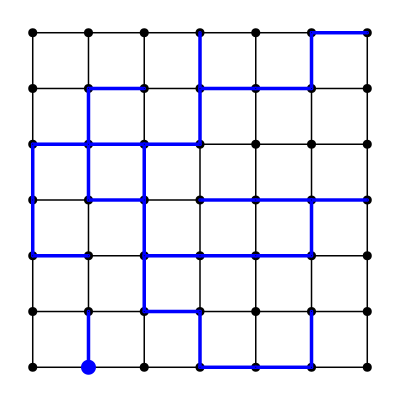

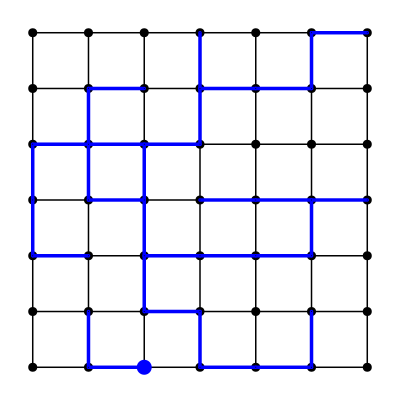

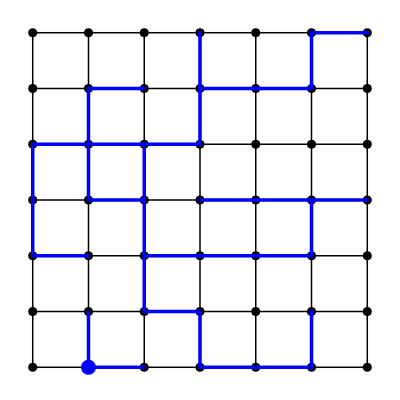

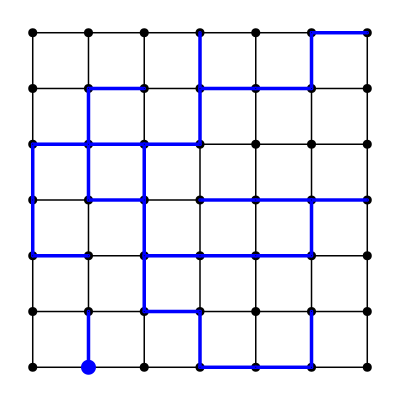

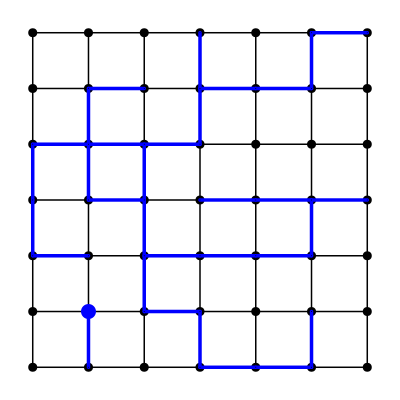

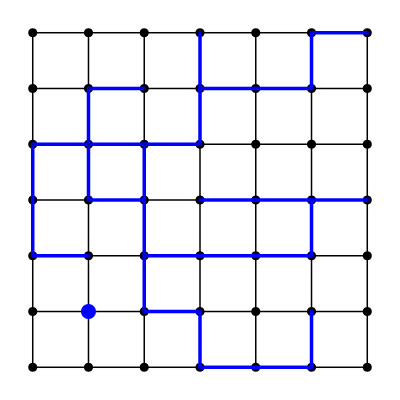

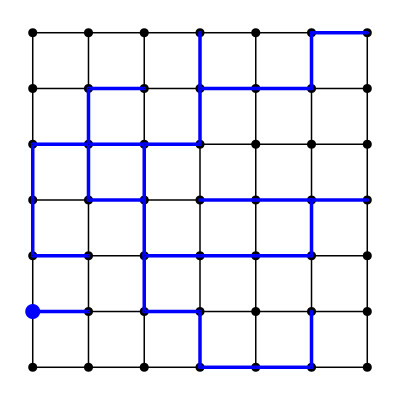

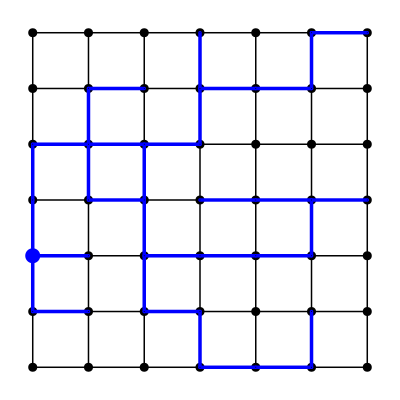

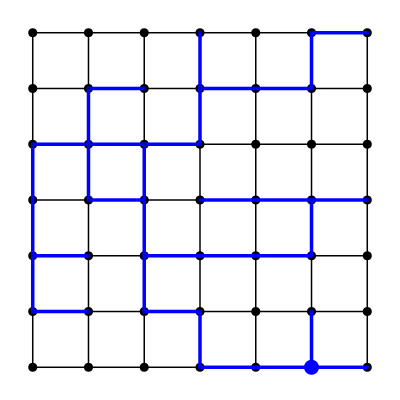

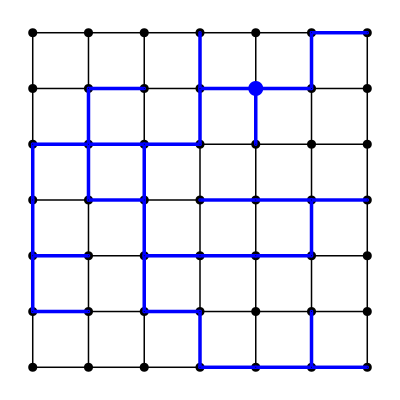

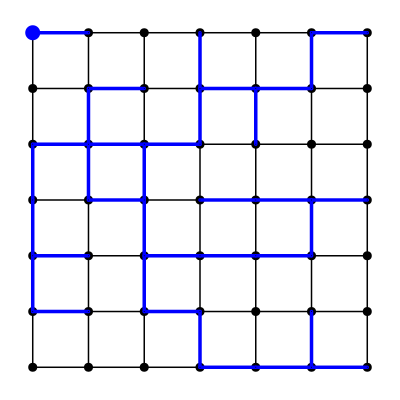

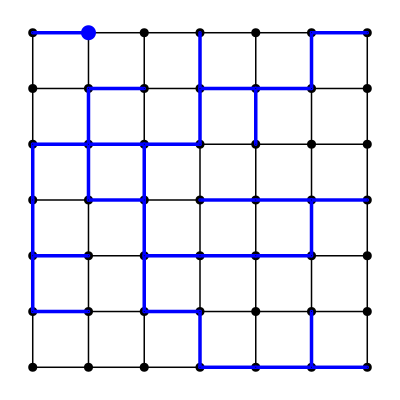

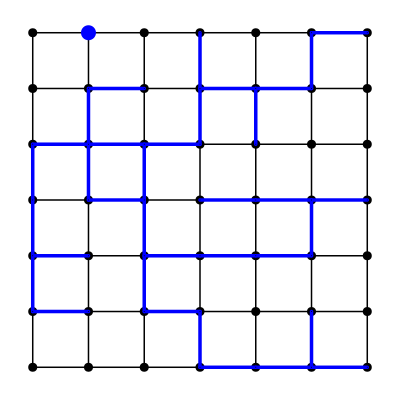

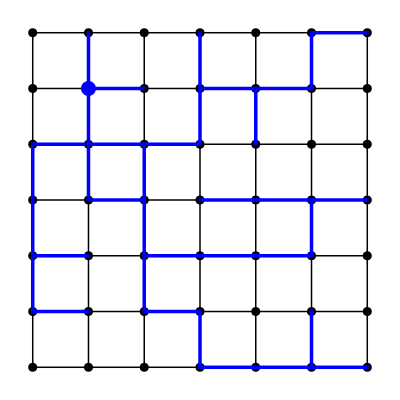

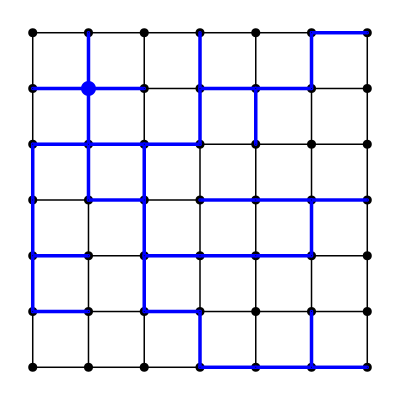

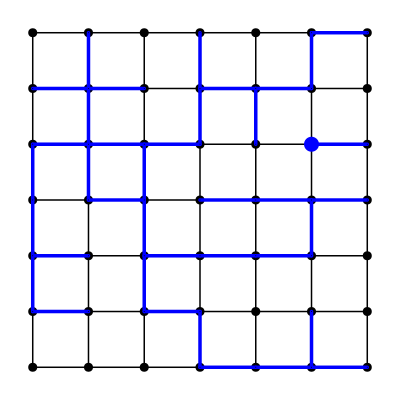

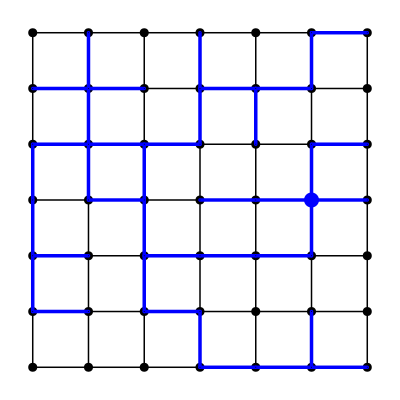

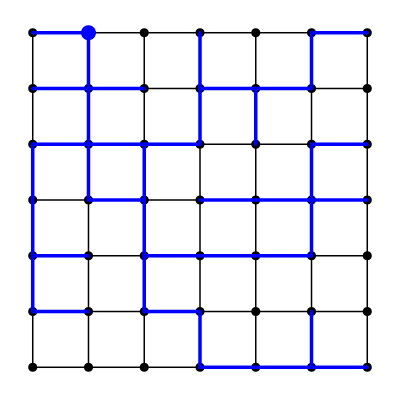

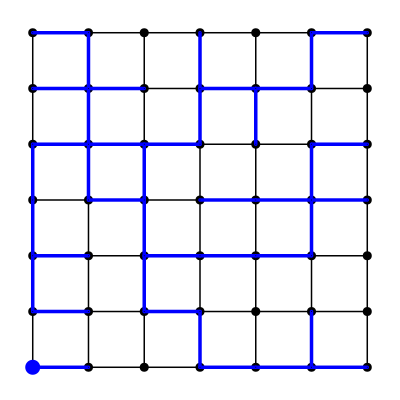

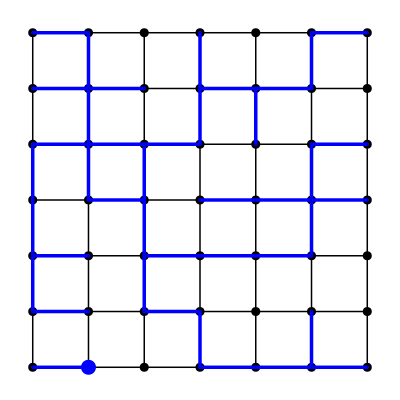

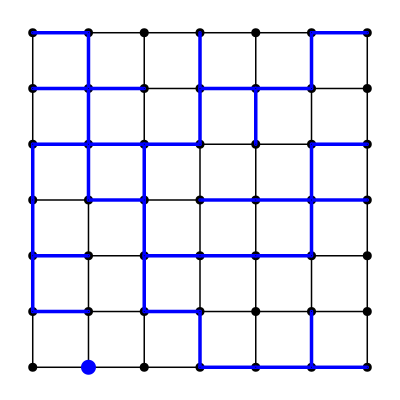

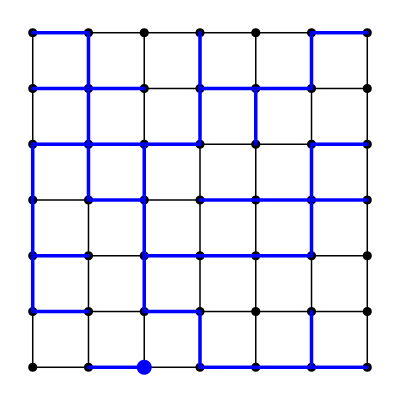

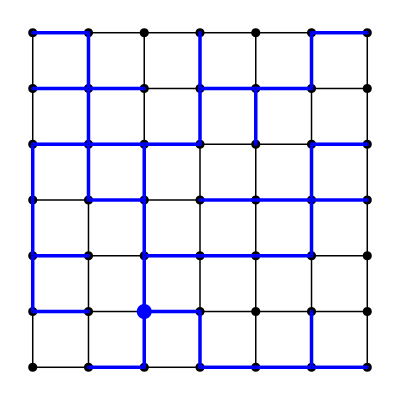

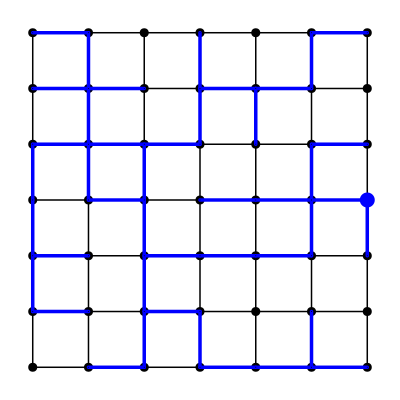

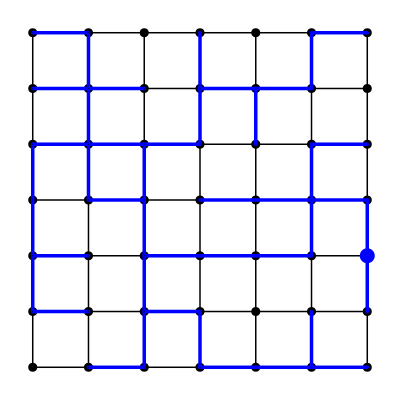

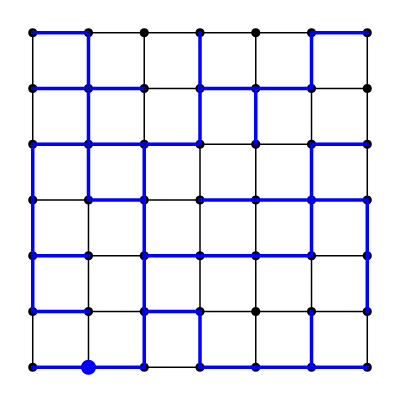

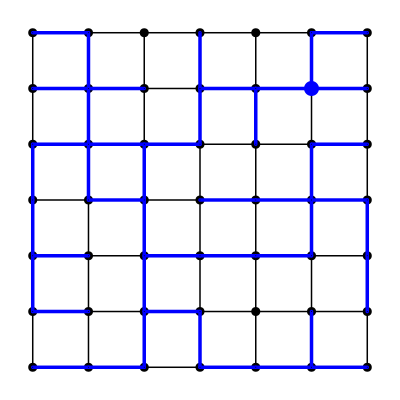

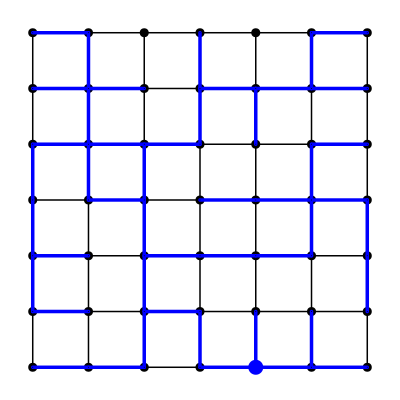

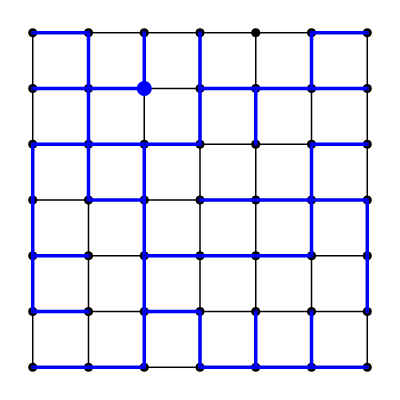

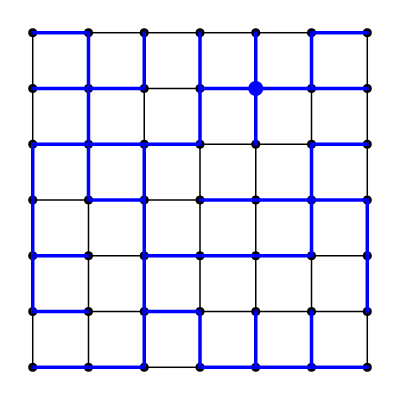

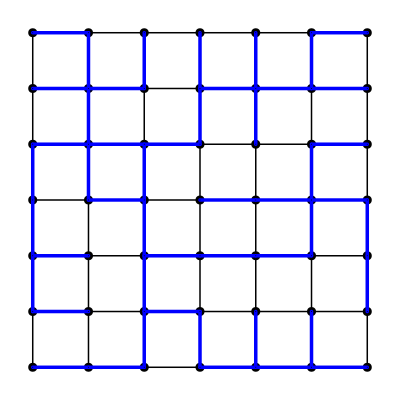

In [52]:
n_frames = length(list_of_graphs)


# f,ax,p = plot_step(list_of_graphs[1],meta_g)
# #scene = plot_step(list_of_graphs[1],meta_g)
# record(f, "test.gif") do io
#     for i in 1:n_frames
#         f,ax,p  = plot_step(list_of_graphs[i],meta_g)
#         recordframe!(io)
#     end
# end


# f,ax,p = plot_step(list_of_graphs[1],meta_g)
# record(f, "test.gif") do io
#     for i in 1:n_frames
#         f,ax,p  = plot_step(list_of_graphs[i],meta_g)
#         recordframe!(io)
#     end
# end

for i = 1:n_frames
    f,ax,p = plot_step(list_of_graphs[i],meta_g)
    display(f)
    name = string(i)
    save("figures/simple_"*name*".png", f, pt_per_unit = 0.5)
    sleep(0.1)
end


In [7]:
using FFMPEG
imagesdirectory = "/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/"
framerate = 10#30
gifname = "/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/gifs/output.gif"
gifpalette = "/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/gifs/palette.png"

#rm(gifname)
#rm(gifpalette)

FFMPEG.ffmpeg_exe(`-framerate $(framerate) -f image2 -i $(imagesdirectory)simple_%1d.png -vf palettegen -y $(gifpalette)`)

FFMPEG.ffmpeg_exe(`-framerate $(framerate) -f image2 -i $(imagesdirectory)simple_%1d.png -i $(gifpalette) -lavfi paletteuse -y $(gifname)`)

# old things

# gifs yellowish
#FFMPEG.ffmpeg_exe(`-framerate $(framerate) -f image2 -i $(imagesdirectory)simple_%1d.png -y $(gifname)`)
# for video work fine
#videoname = "/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/gifs/output.mov"
#FFMPEG.ffmpeg_exe(`-framerate $(framerate) -f image2 -i $(imagesdirectory)simple_%1d.png -vf "scale=1080:1080" -c:v libx264 -pix_fmt yuv420p -y $(videoname)`)

ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with clang version 11.0.1 (/home/ec2-user/.julia/dev/BinaryBuilderBase/deps/downloads/llvm-project.git 43ff75f2c3feef64f9d73328230d34dac8832a91)
  configuration: --enable-cross-compile --cross-prefix=/opt/x86_64-apple-darwin14/bin/x86_64-apple-darwin14- --arch=x86_64 --target-os=darwin --cc=cc --cxx=c++ --dep-cc=cc --ar=ar --nm=nm --sysinclude=/workspace/destdir/include --pkg-config=/usr/bin/pkg-config --pkg-config-flags=--static --prefix=/workspace/destdir --sysroot=/opt/x86_64-apple-darwin14/x86_64-apple-darwin14/sys-root --extra-libs=-lpthread --enable-gpl --enable-version3 --enable-nonfree --disable-static --enable-shared --enable-pic --disable-debug --disable-doc --enable-avresample --enable-libass --enable-libfdk-aac --enable-libfreetype --enable-libmp3lame --enable-libopus --enable-libvorbis --enable-libx264 --enable-libx265 --enable-libvpx --enable-encoders --enable-decoders --enable-muxers --enable-demuxe

Input #0, image2, from '/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/simple_%1d.png':
  Duration: 00:00:23.80, start: 0.000000, bitrate: N/A
  Stream #0:0: Video: png, rgb24(pc), 400x400, 10 fps, 10 tbr, 10 tbn, 10 tbc
Stream mapping:
  Stream #0:0 -> #0:0 (png (native) -> png (native))
Press [q] to stop, [?] for help


[Parsed_palettegen_0 @ 0x7fef134128c0] 255(+1) colors generated out of 891 colors; ratio=0.286195
[Parsed_palettegen_0 @ 0x7fef134128c0] Dupped color: FF0000FC
Output #0, image2, to '/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/gifs/palette.png':
  Metadata:
    encoder         : Lavf58.76.100
  Stream #0:0: Video: png, rgba(pc, progressive), 16x16 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 10 fps, 10 tbn
    Metadata:
      encoder         : Lavc58.134.100 png
frame=    1 fps=0.0 q=-0.0 Lsize=N/A time=00:00:00.10 bitrate=N/A speed=0.22x    
video:1kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: unknown
ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with clang version 11.0.1 (/home/ec2-user/.julia/dev/BinaryBuilderBase/deps/downloads/llvm-project.git 43ff75f2c3feef64f9d73328230d34dac8832a91)
  configuration: --enable-cross-compile --cross-prefix=/opt/x86_64-apple-darwin14/bin/x86_64-apple-darwin14-

Input #0, image2, from '/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/simple_%1d.png':
  Duration: 00:00:23.80, start: 0.000000, bitrate: N/A
  Stream #0:0: Video: png, rgb24(pc), 400x400, 10 fps, 10 tbr, 10 tbn, 10 tbc
Input #1, png_pipe, from '/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/gifs/palette.png':
  Duration: N/A, bitrate: N/A
  Stream #1:0: Video: png, rgba(pc), 16x16 [SAR 1:1 DAR 1:1], 25 fps, 25 tbr, 25 tbn, 25 tbc
Stream mapping:
  Stream #0:0 (png) -> paletteuse:default
  Stream #1:0 (png) -> paletteuse:palette
  paletteuse -> Stream #0:0 (gif)
Press [q] to stop, [?] for help
[image2 @ 0x7ffe5f808200] Thread message queue blocking; consider raising the thread_queue_size option (current value: 8)
Output #0, gif, to '/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/gifs/output.gif':
  Metadata:
    encoder         : Lavf58.76.100
  Stream #0:0: Video: gif, pal

frame=  238 fps=202 q=-0.0 Lsize=      80kB time=00:00:23.71 bitrate=  27.8kbits/s speed=20.1x    
video:80kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.024289%


Process(`/Users/mfanuel/.julia/artifacts/d30bf8e9f9b903de5e42ffdad9e1118722c08cd8/bin/ffmpeg -framerate 10 -f image2 -i /Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/simple_%1d.png -i /Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/gifs/palette.png -lavfi paletteuse -y /Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/gifs/output.gif`, ProcessExited(0))

ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with clang version 11.0.1 (/home/ec2-user/.julia/dev/BinaryBuilderBase/deps/downloads/llvm-project.git 43ff75f2c3feef64f9d73328230d34dac8832a91)
  configuration: --enable-cross-compile --cross-prefix=/opt/x86_64-apple-darwin14/bin/x86_64-apple-darwin14- --arch=x86_64 --target-os=darwin --cc=cc --cxx=c++ --dep-cc=cc --ar=ar --nm=nm --sysinclude=/workspace/destdir/include --pkg-config=/usr/bin/pkg-config --pkg-config-flags=--static --prefix=/workspace/destdir --sysroot=/opt/x86_64-apple-darwin14/x86_64-apple-darwin14/sys-root --extra-libs=-lpthread --enable-gpl --enable-version3 --enable-nonfree --disable-static --enable-shared --enable-pic --disable-debug --disable-doc --enable-avresample --enable-libass --enable-libfdk-aac --enable-libfreetype --enable-libmp3lame --enable-libopus --enable-libvorbis --enable-libx264 --enable-libx265 --enable-libvpx --enable-encoders --enable-decoders --enable-muxers --enable-demuxe

frame=  238 fps=155 q=-0.0 Lsize=      80kB time=00:00:23.71 bitrate=  27.8kbits/s speed=15.5x    
video:80kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.024289%


Process(`/Users/mfanuel/.julia/artifacts/d30bf8e9f9b903de5e42ffdad9e1118722c08cd8/bin/ffmpeg -framerate 10 -f image2 -i /Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/simple_%1d.png -i /Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/gifs/palette.png -lavfi paletteuse -y /Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/gifs/output.gif`, ProcessExited(0))